In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from collections import defaultdict
from mmit.core.solver import compute_optimal_costs
from mmit.learning import MaxMarginIntervalTree
from mmit.metrics import mean_squared_error, zero_one_loss
from mmit.model import TreeExporter
from mmit.model_selection import GridSearchCV
from time import time

In [2]:
class Dataset(object):
    def __init__(self, path):
        self.path = path
        feature_data = pd.read_csv(os.path.join(path, "features.csv"))
        self.X = feature_data.values
        self.feature_names = feature_data.columns.values
        del feature_data
        self.y = pd.read_csv(os.path.join(path, "targets.csv")).values
        self.folds = pd.read_csv(os.path.join(path, "folds.csv")).values.reshape(-1, )
        self.name = os.path.basename(path)
    
    @property
    def n_examples(self):
        return self.X.shape[0]
    
    @property
    def n_features(self):
        return self.X.shape[1]
    
def find_datasets(path):
    for d in os.listdir(path):
        if os.path.exists(os.path.join(path, d, "features.csv")) and \
           os.path.exists(os.path.join(path, d, "targets.csv")) and \
           os.path.exists(os.path.join(path, d, "folds.csv")):
            yield Dataset(os.path.abspath(os.path.join(path, d)))

In [7]:
def plot_estimator_surface(dataset, estimator):
    cm = plt.cm.jet

    plt.clf()
    plt.scatter(dataset.X[:, 0], dataset.X[:, 1])

    ax = plt.gca()

    h = .02  # step size in the mesh
    x_min, x_max = dataset.X[:, 0].min() - .5, dataset.X[:, 0].max() + .5
    y_min, y_max = dataset.X[:, 1].min() - .5, dataset.X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Put the result into a color plot
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    surface = ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    plt.colorbar(surface)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    plt.gcf().set_size_inches(12, 10)
    plt.title("{0!s} -- {1!s}".format(dataset.name, estimator))
    plt.savefig("prediction_surface_{0!s}_{1!s}.pdf".format(dataset.name, estimator), bbox_inches="tight")
    plt.show()

Estimator training cost: 71.630825
Estimator n_rules: 7


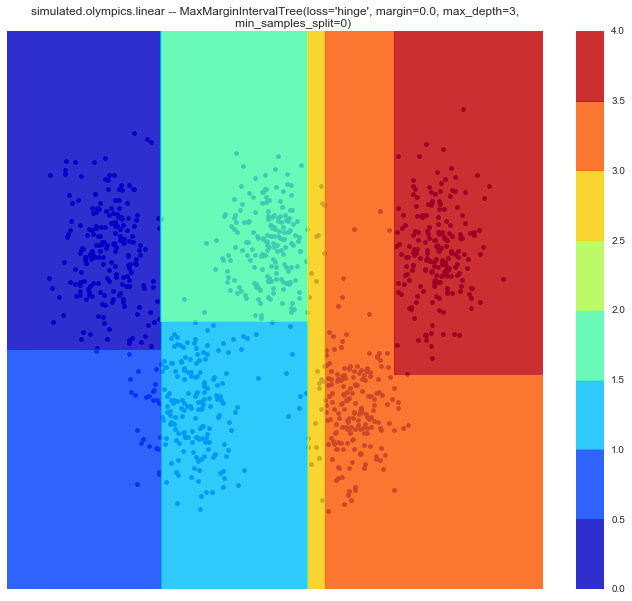

In [8]:
dataset = Dataset("./data/simulated.olympics.linear")

estimator = MaxMarginIntervalTree(max_depth=3, margin=0.)
estimator.fit(dataset.X, dataset.y)
print "Estimator training cost:", sum(l.cost_value for l in estimator.tree_.leaves)
print "Estimator n_rules:", len(estimator.tree_.rules)
plot_estimator_surface(dataset, estimator)

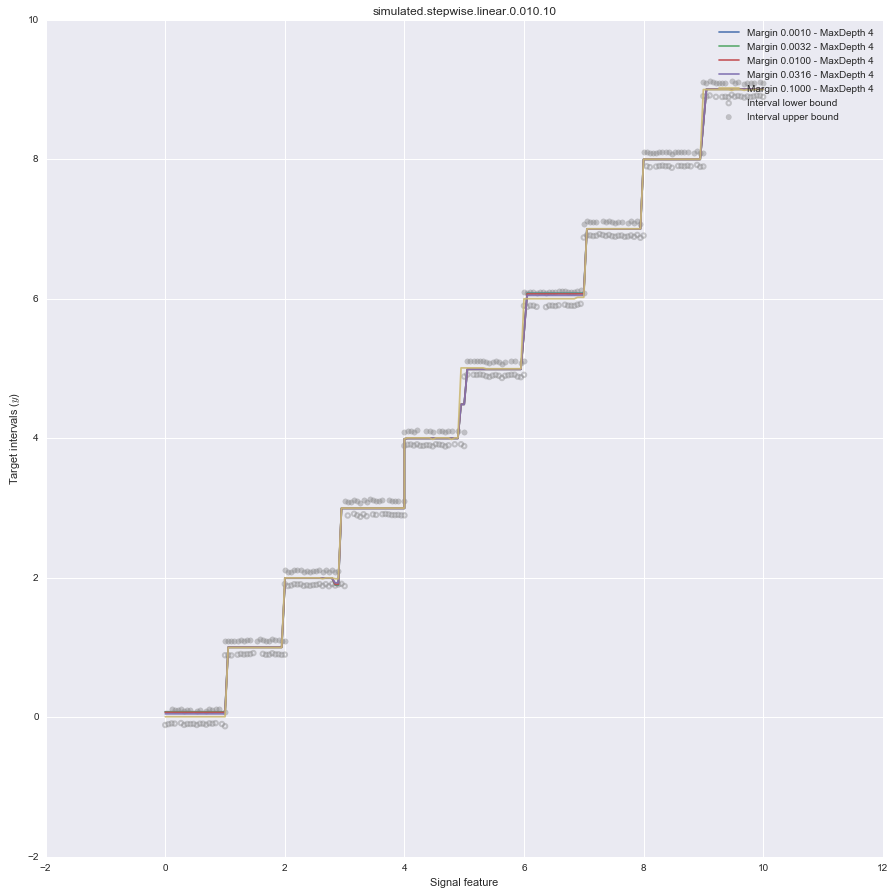

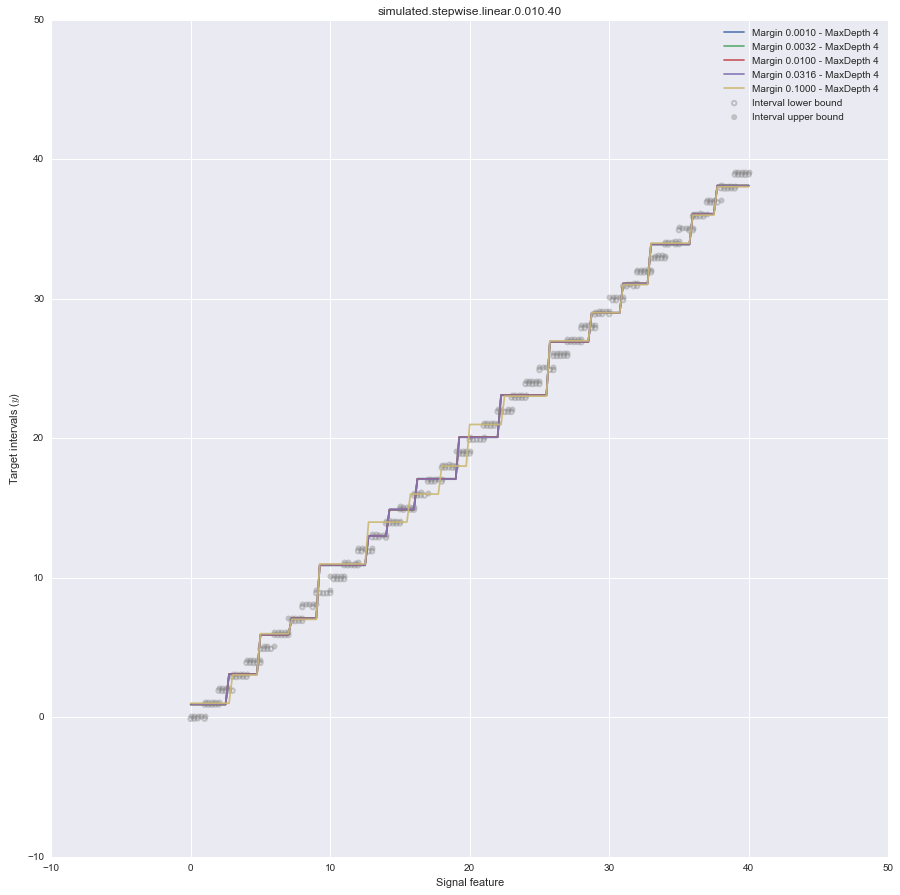

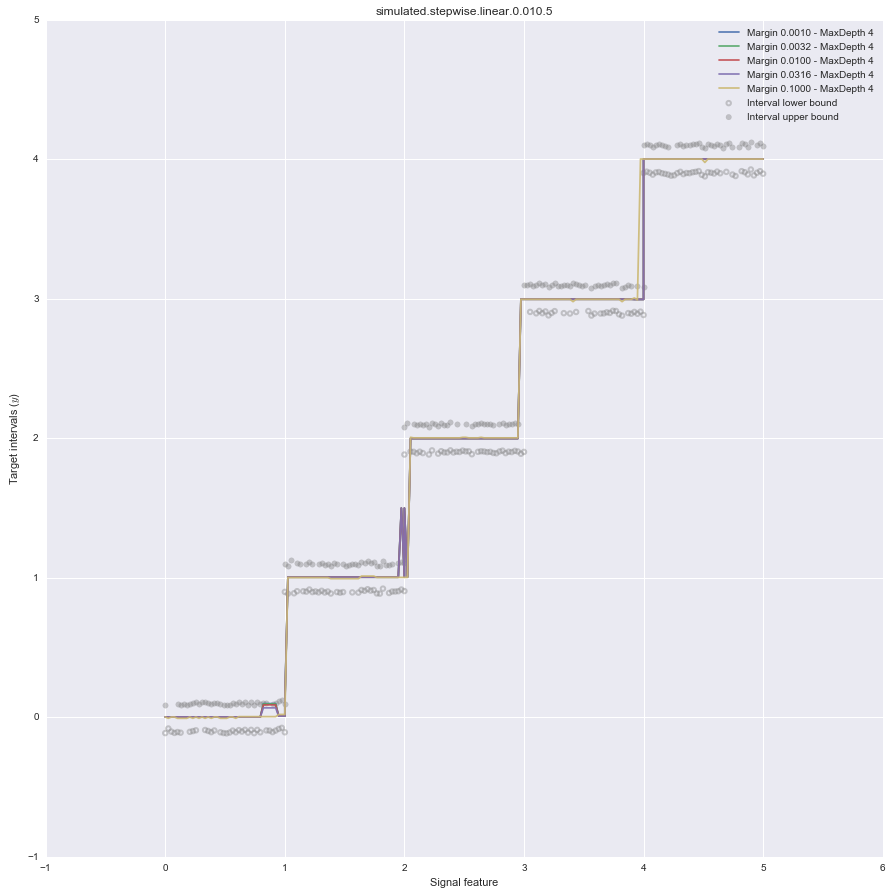

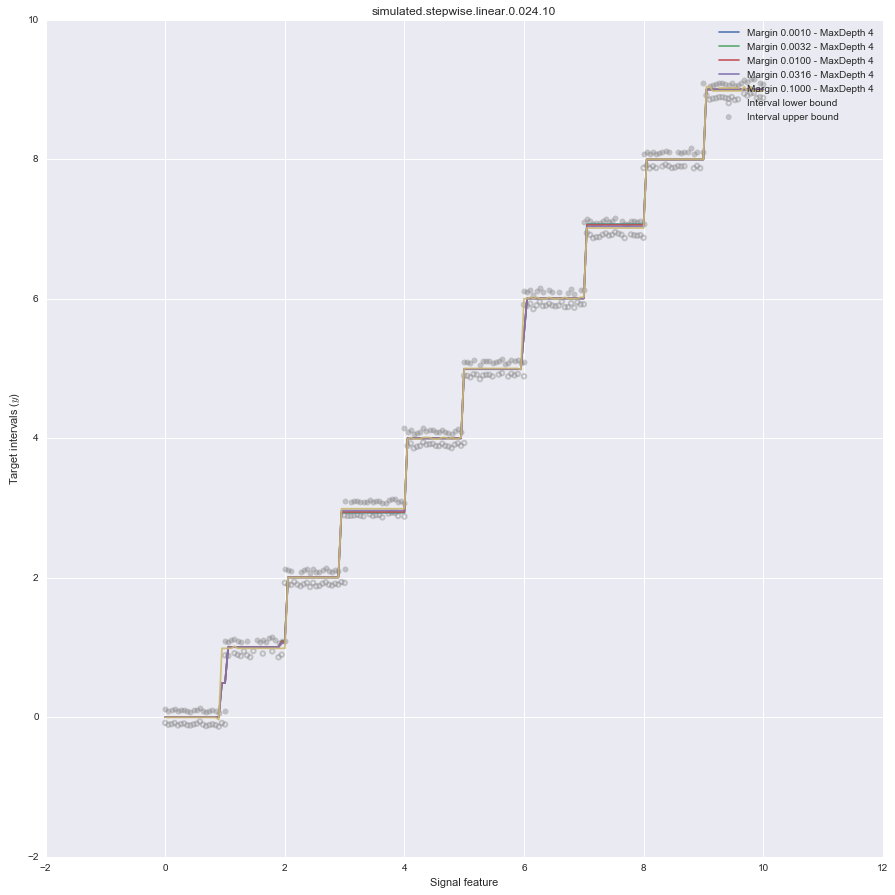

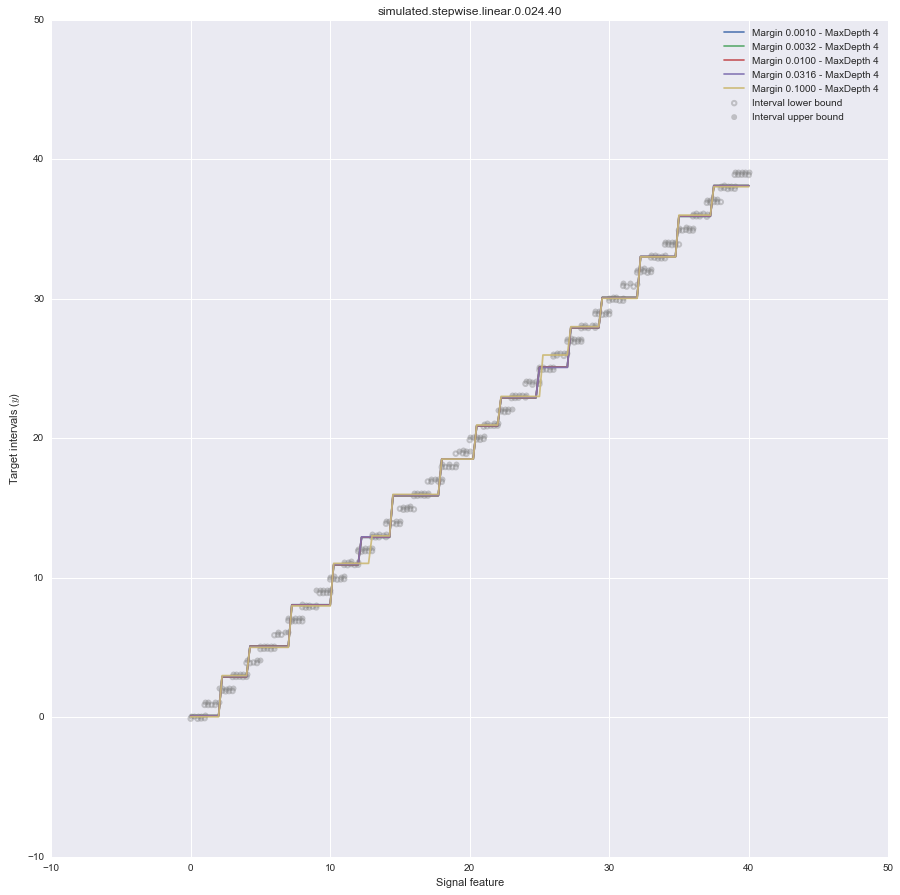

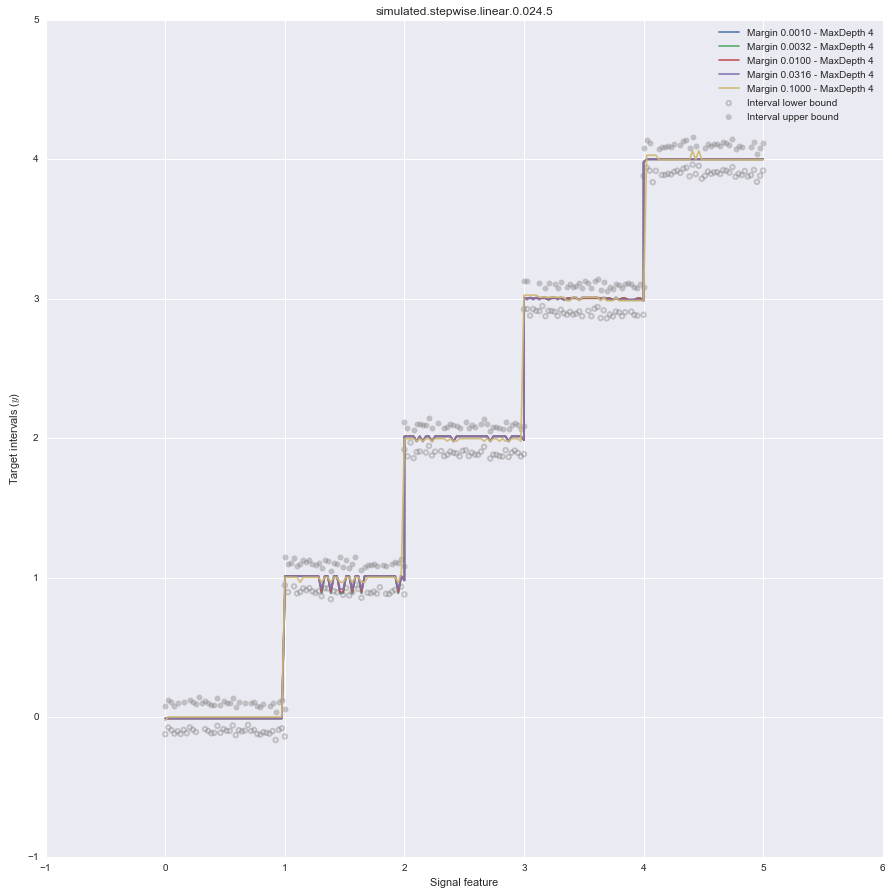

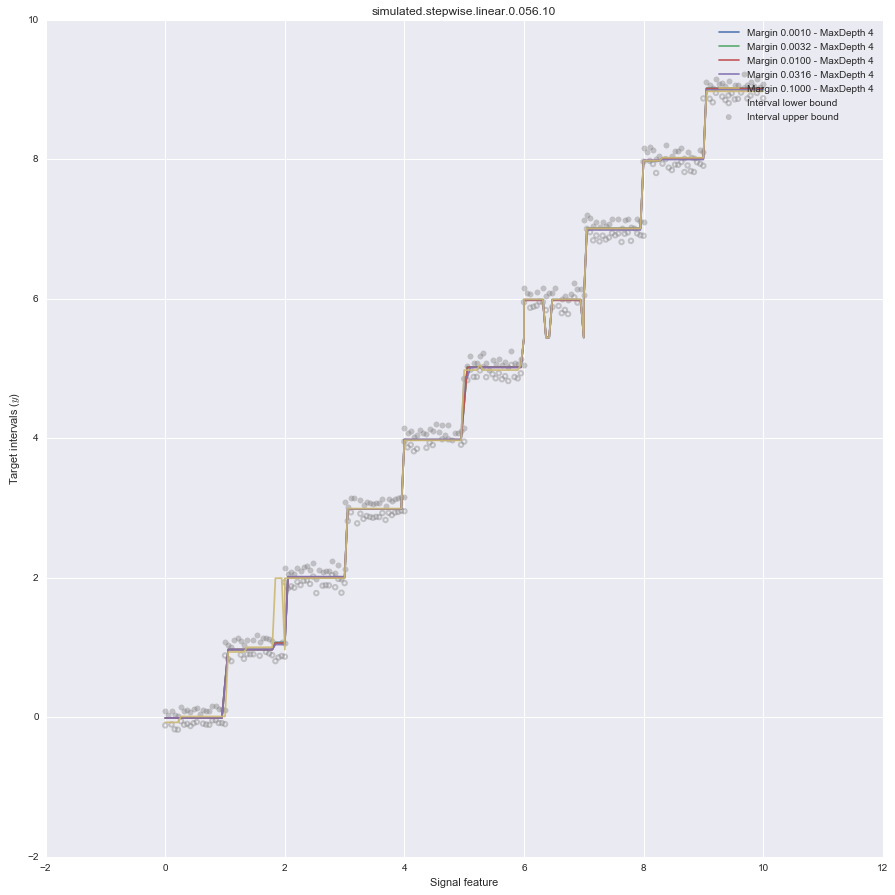

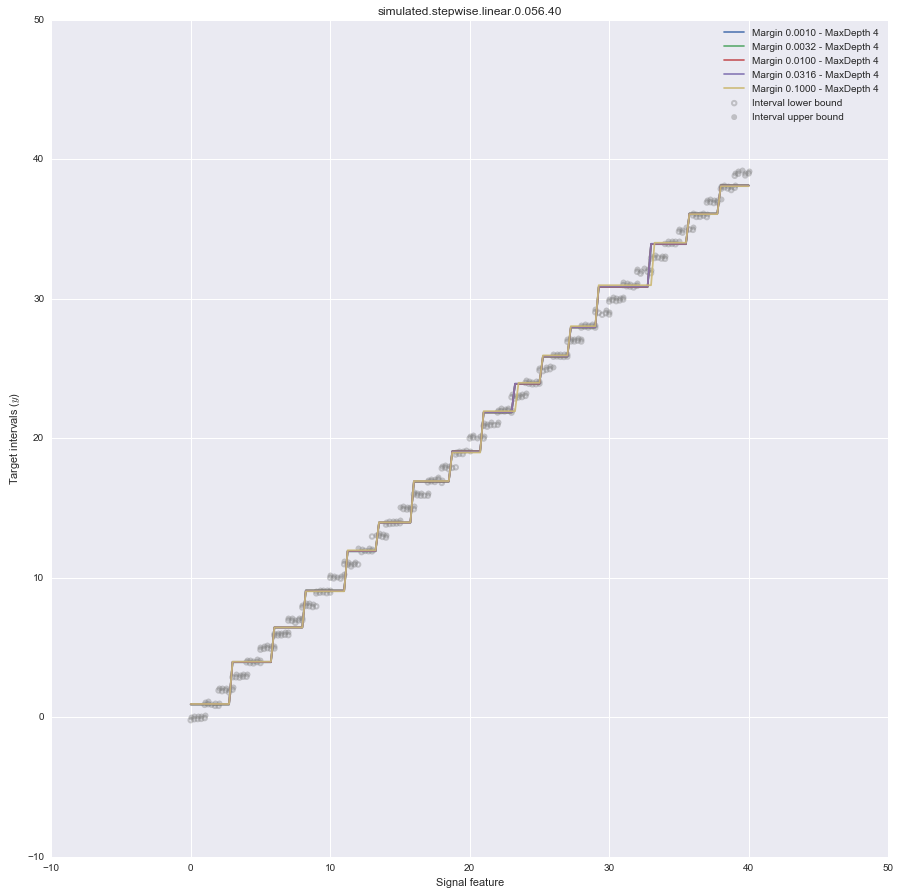

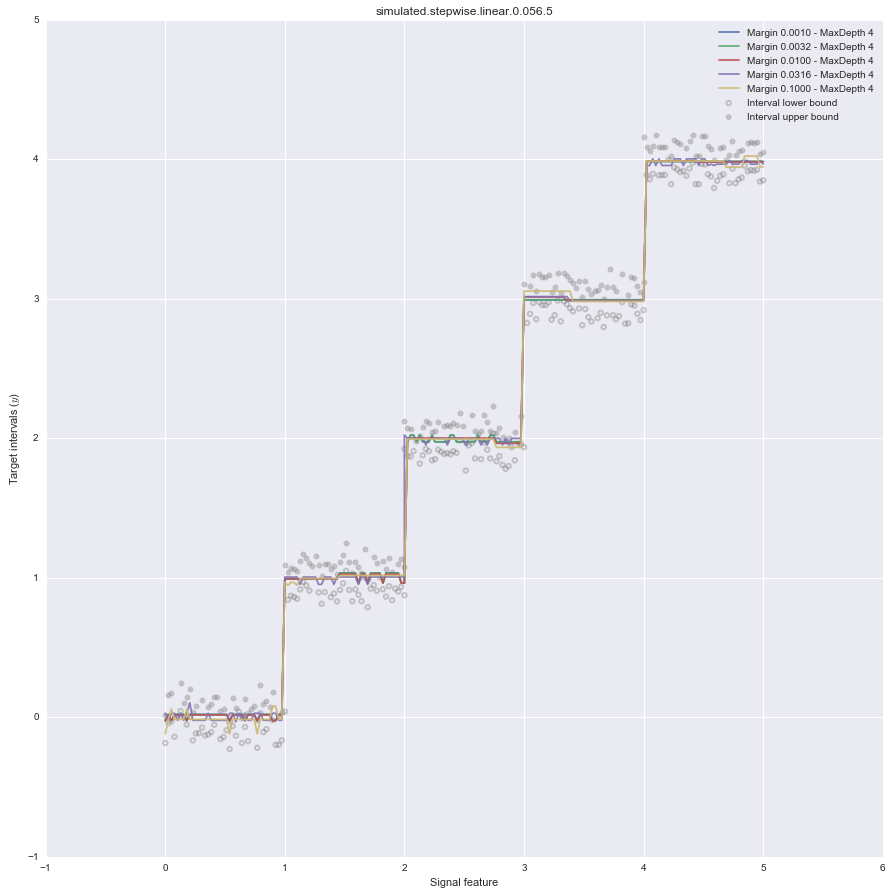

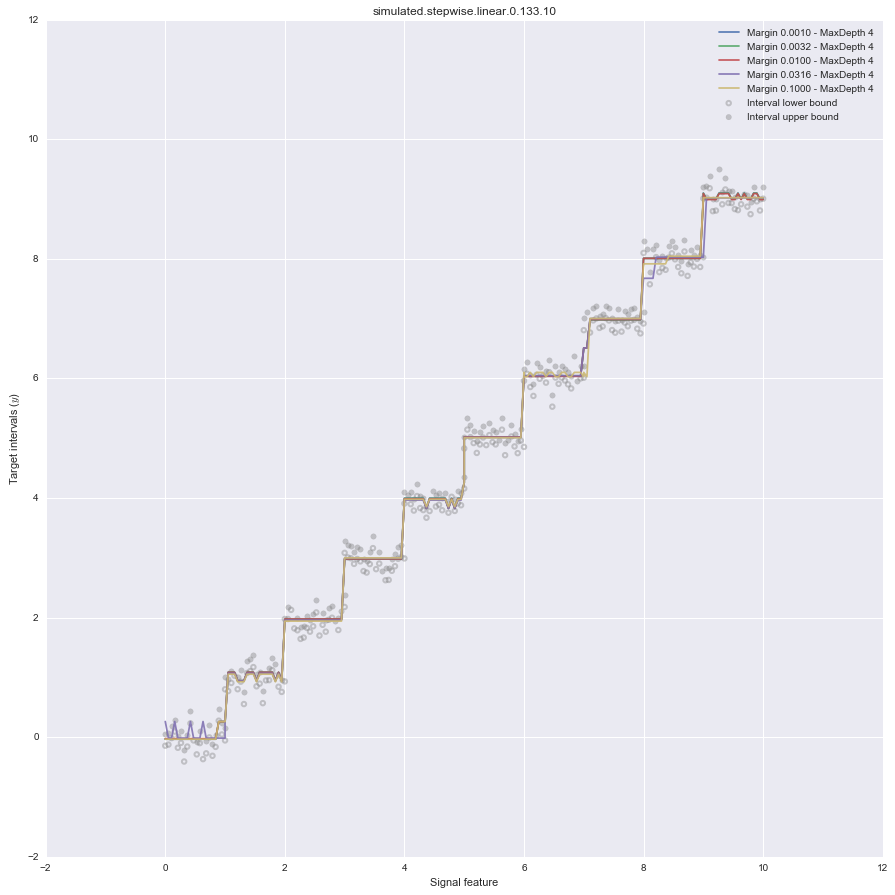

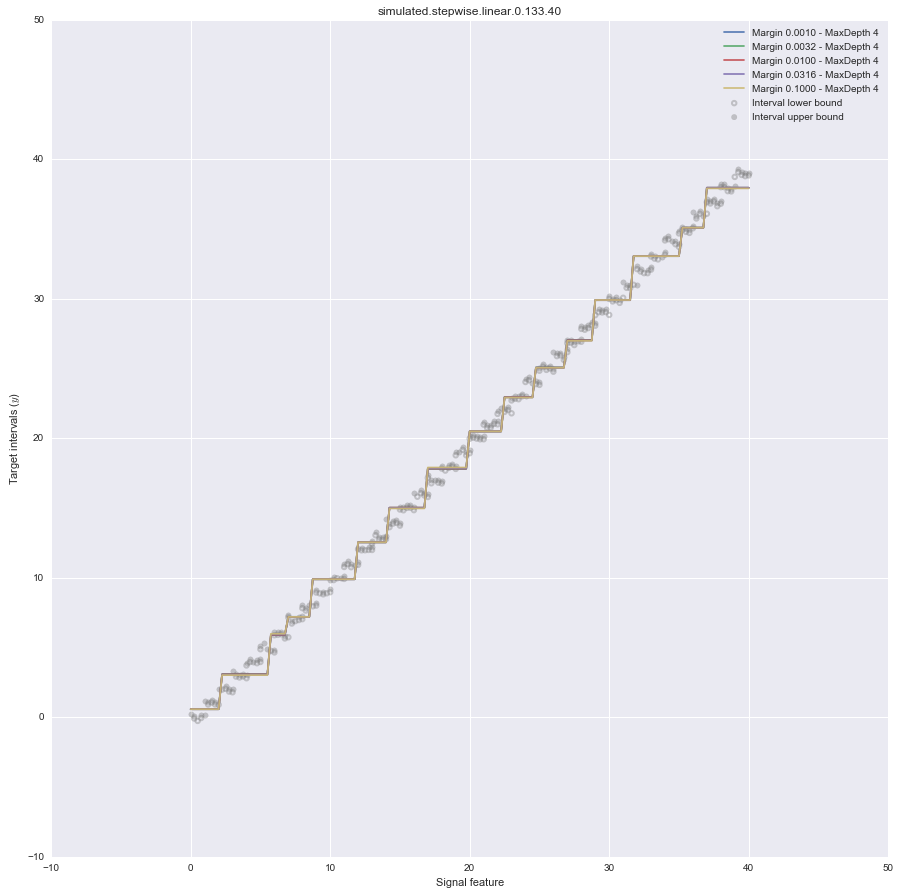

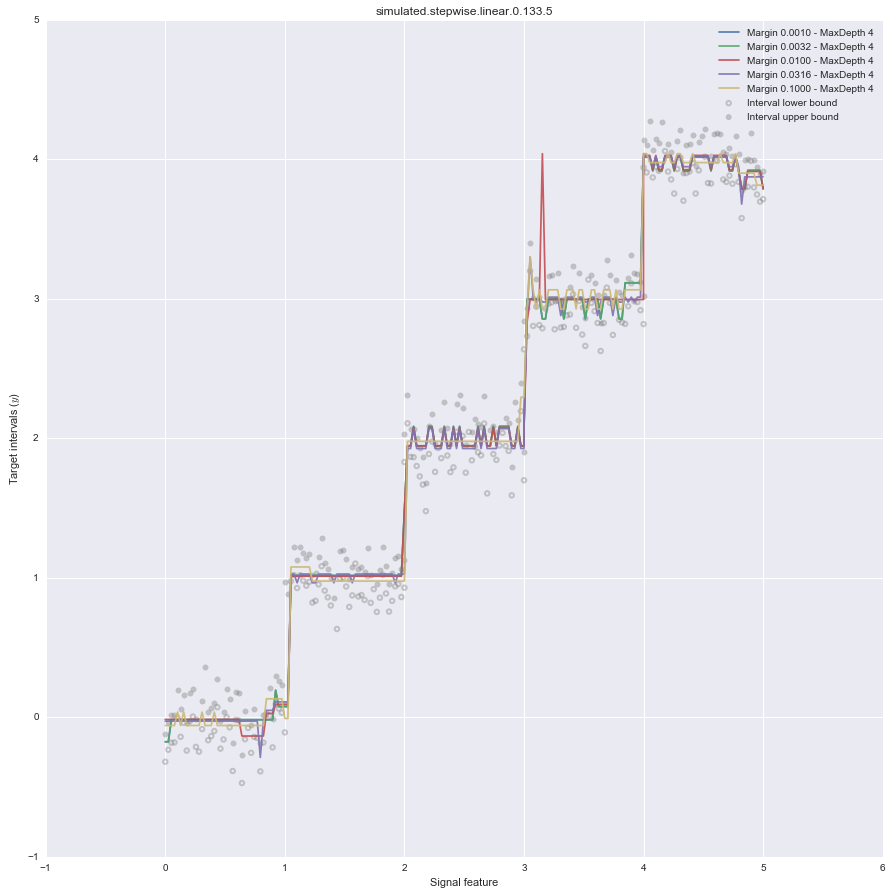

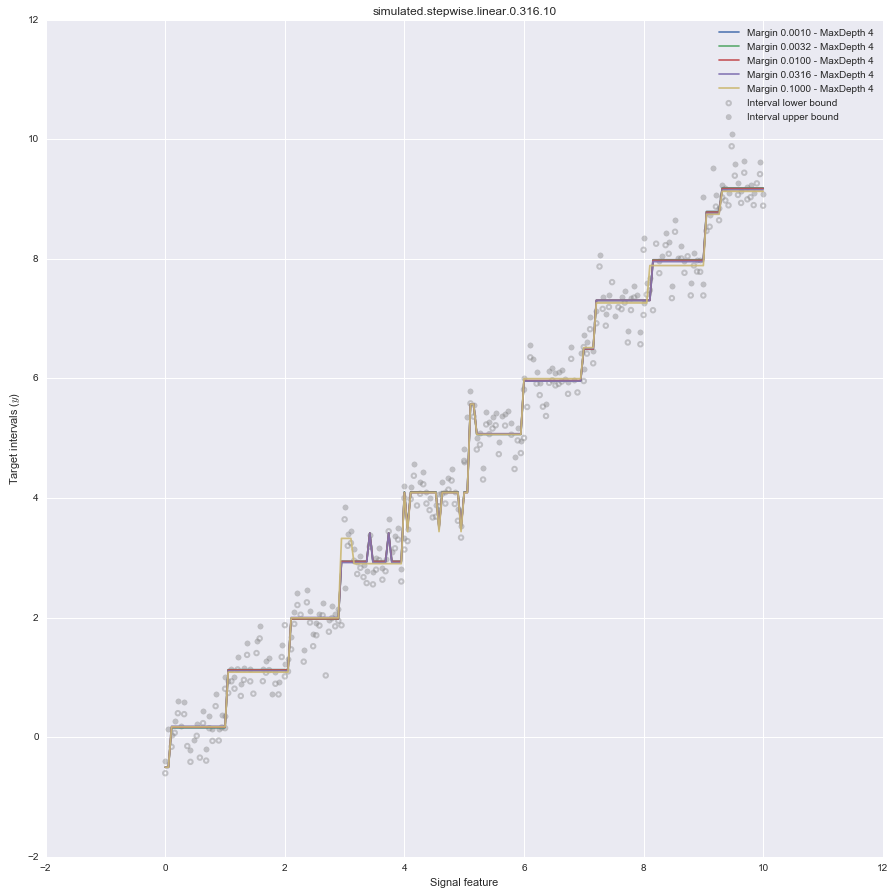

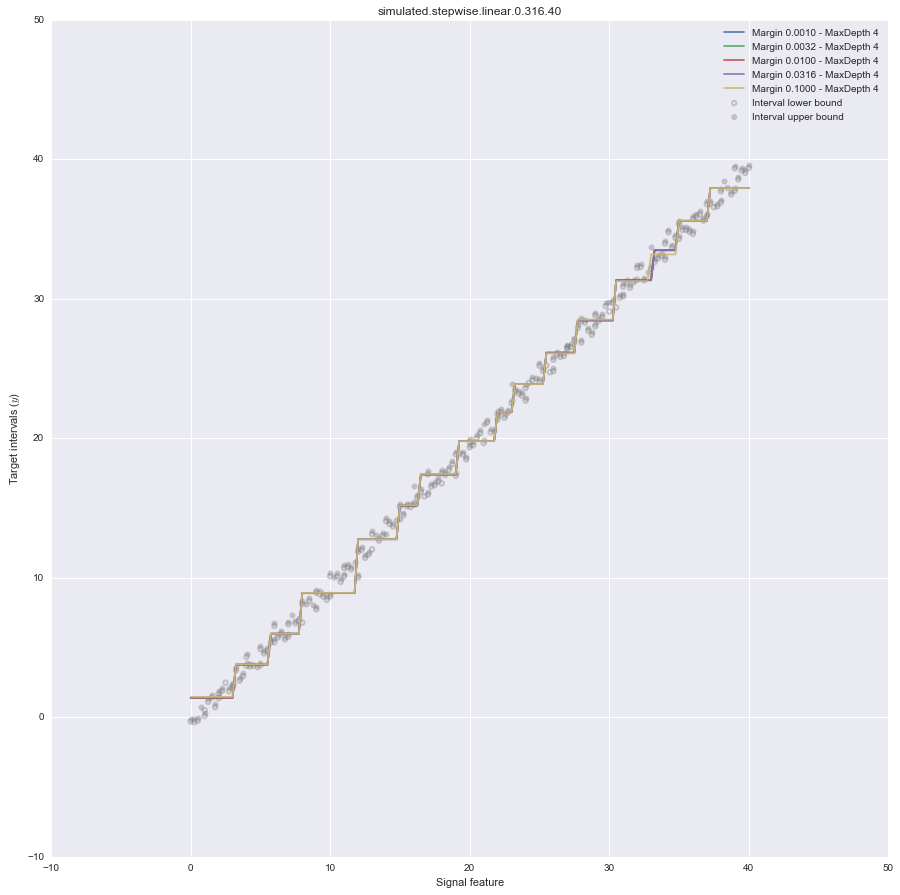

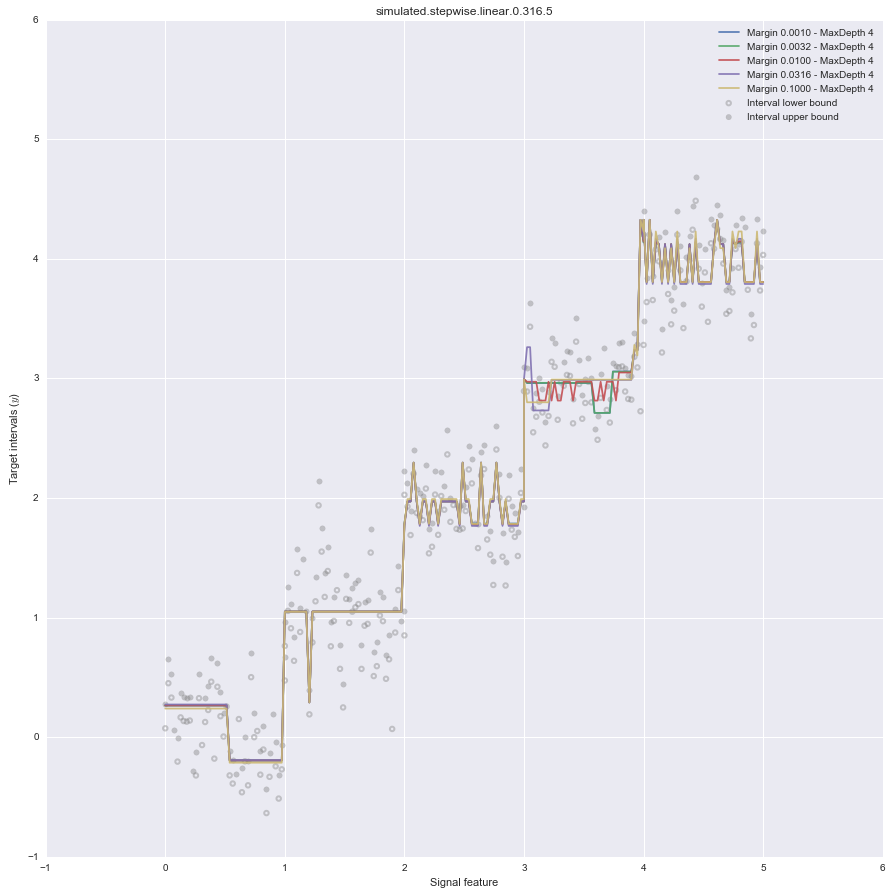

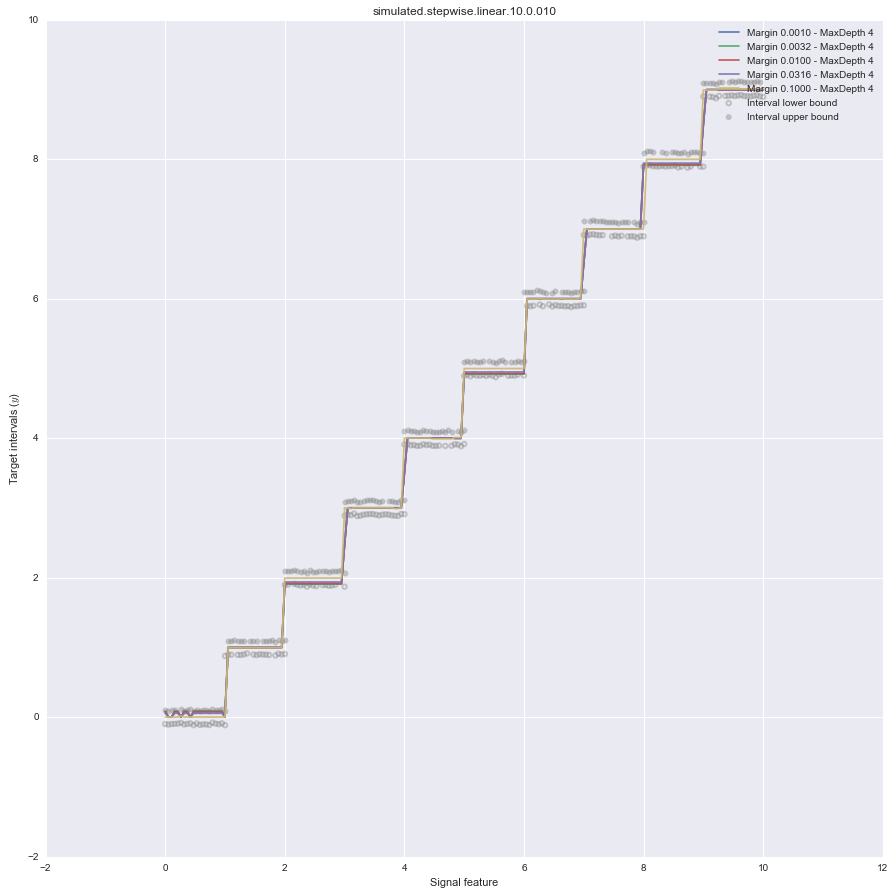

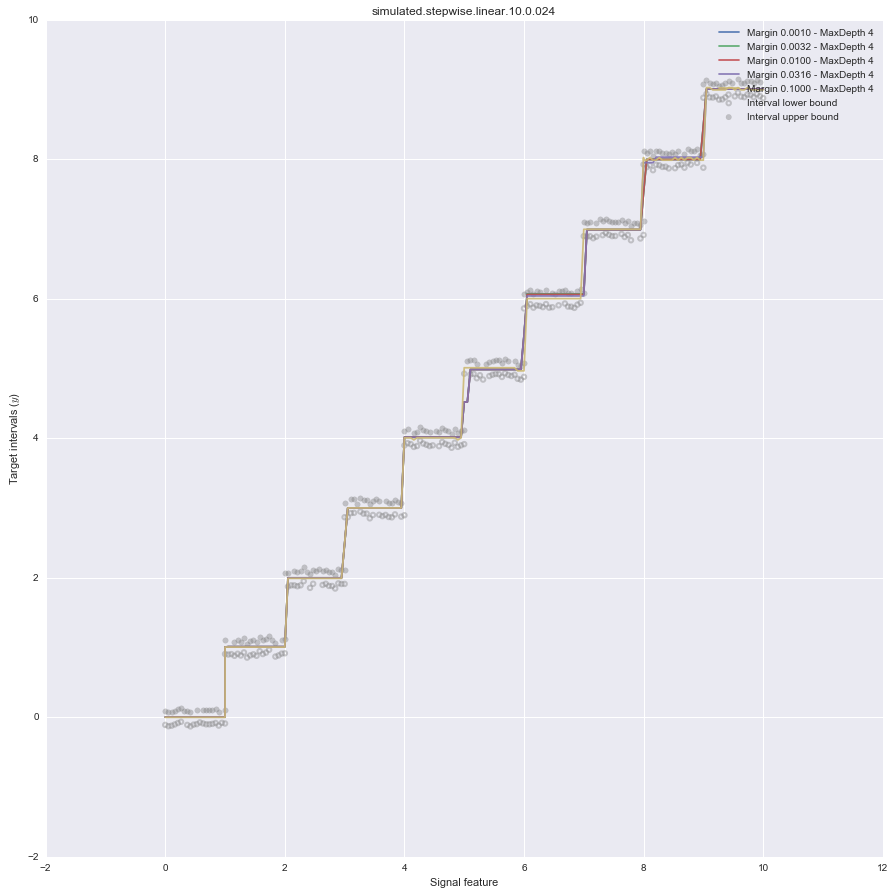

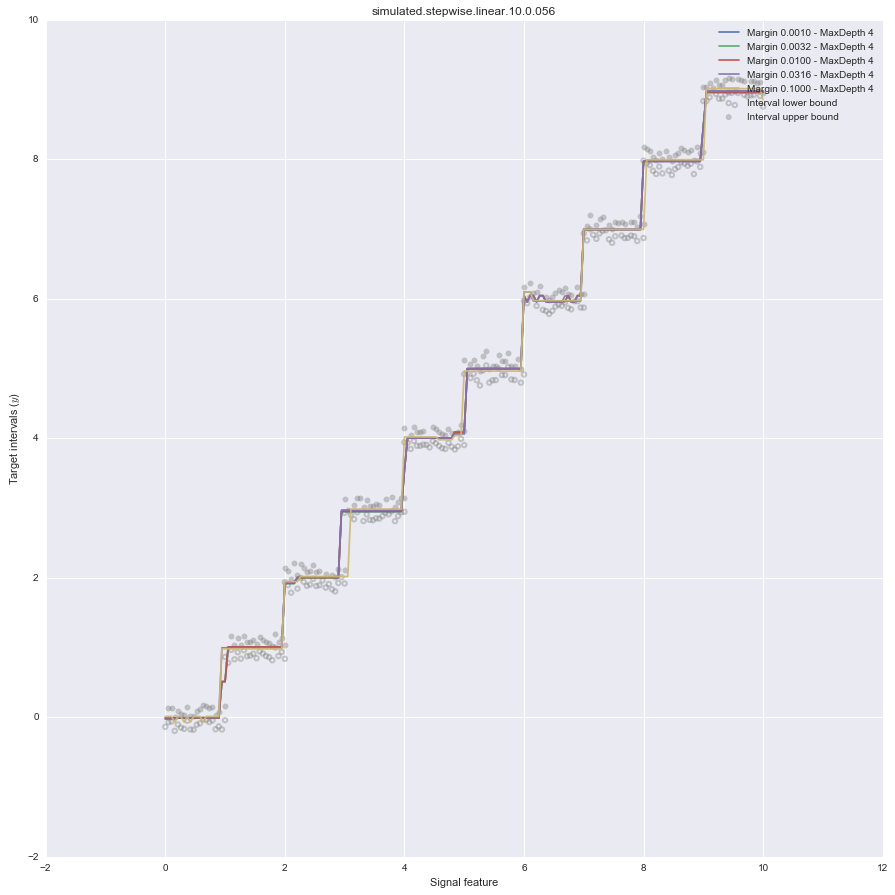

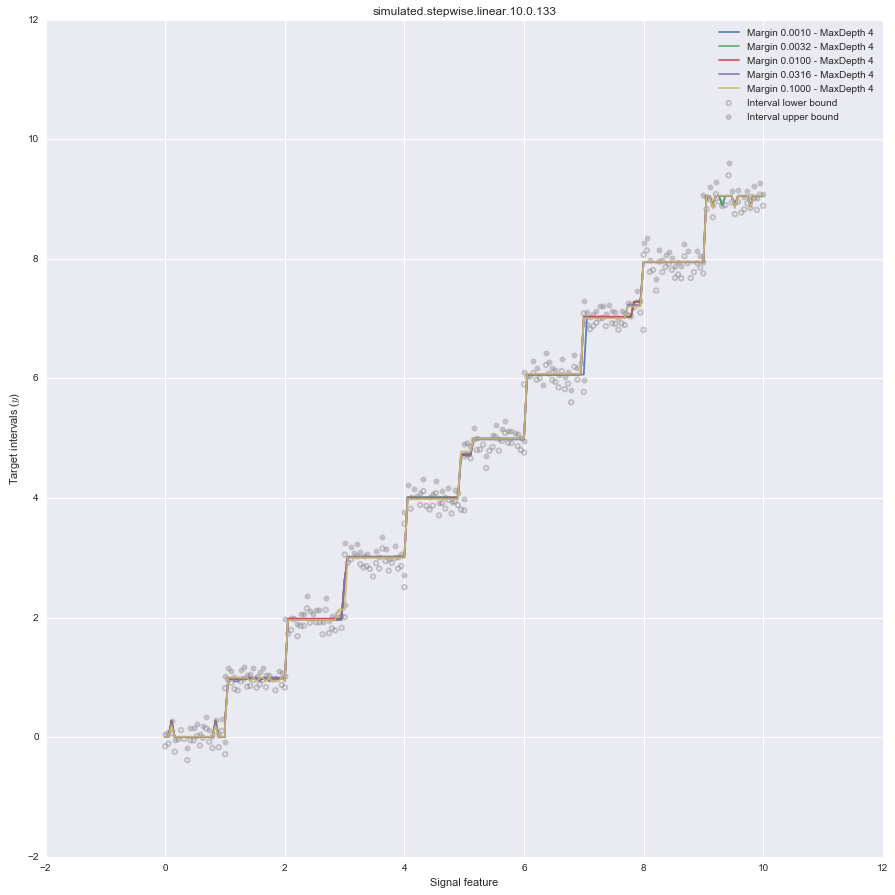

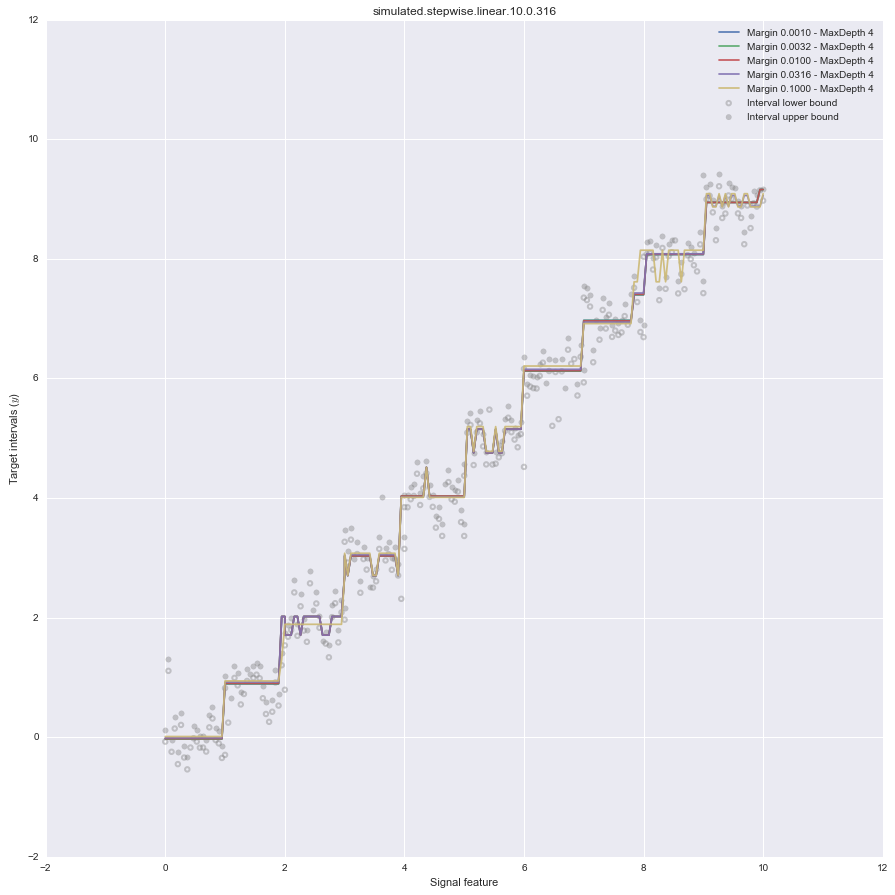

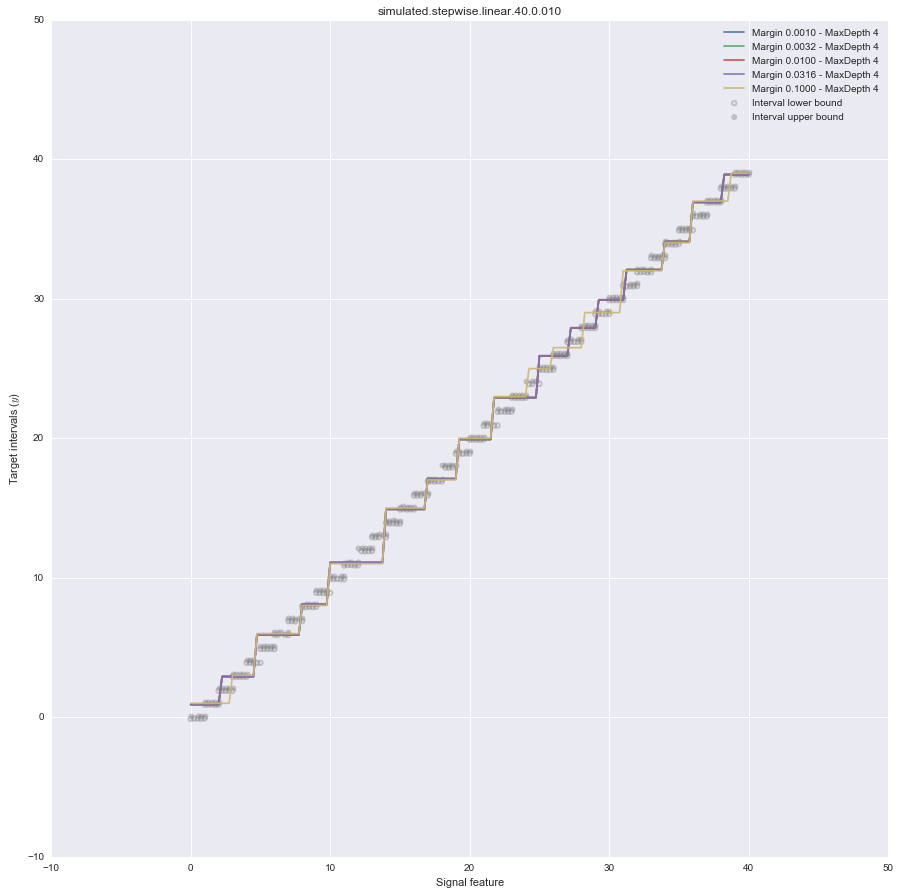

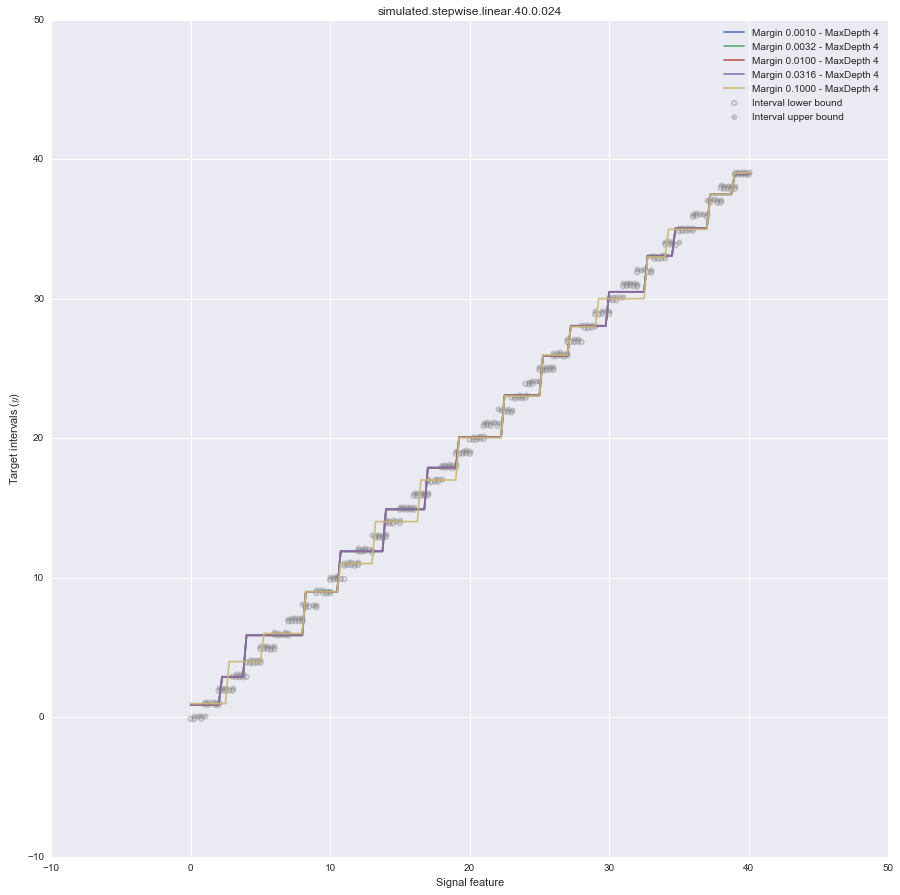

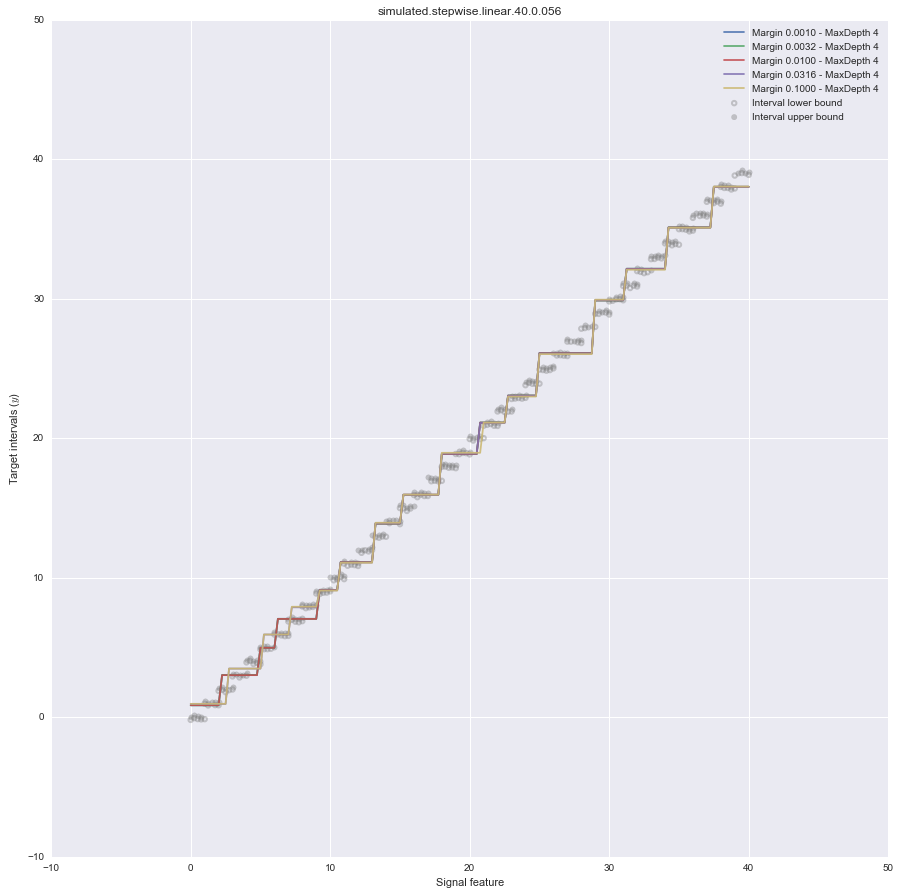

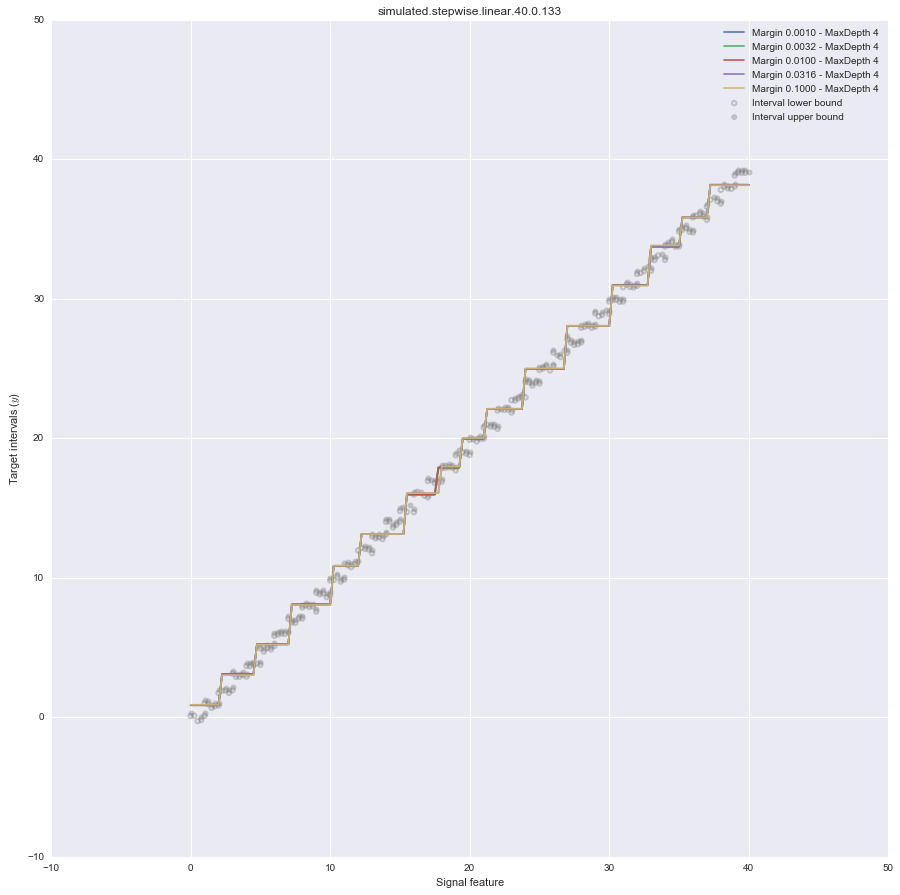

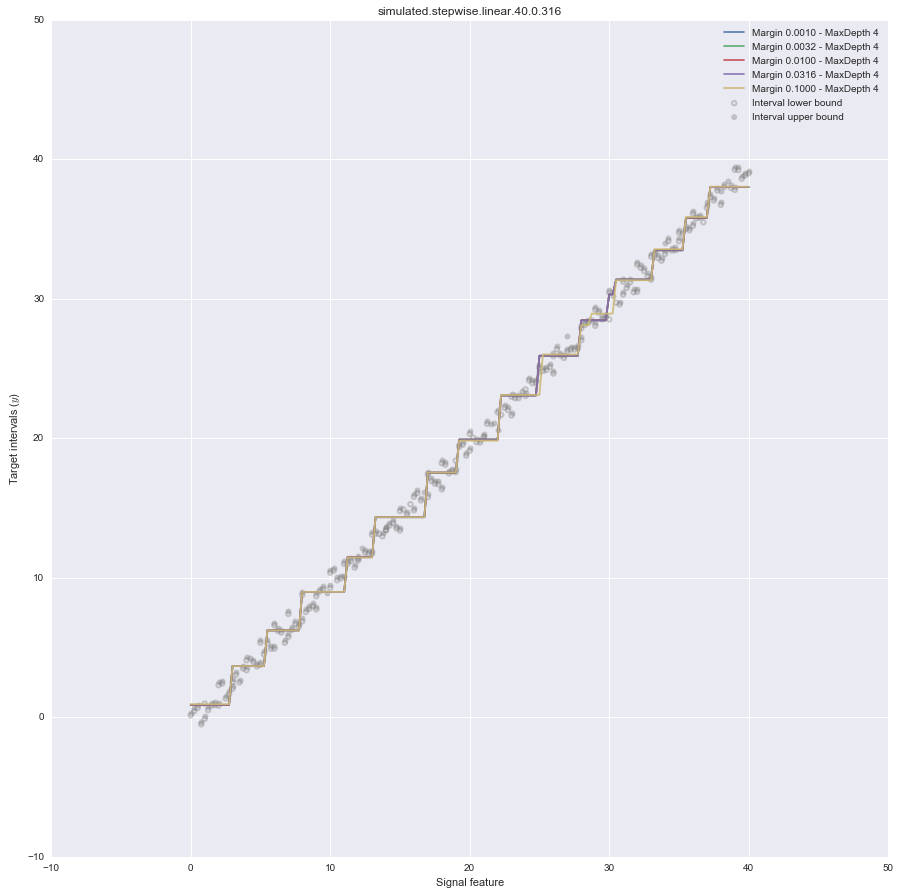

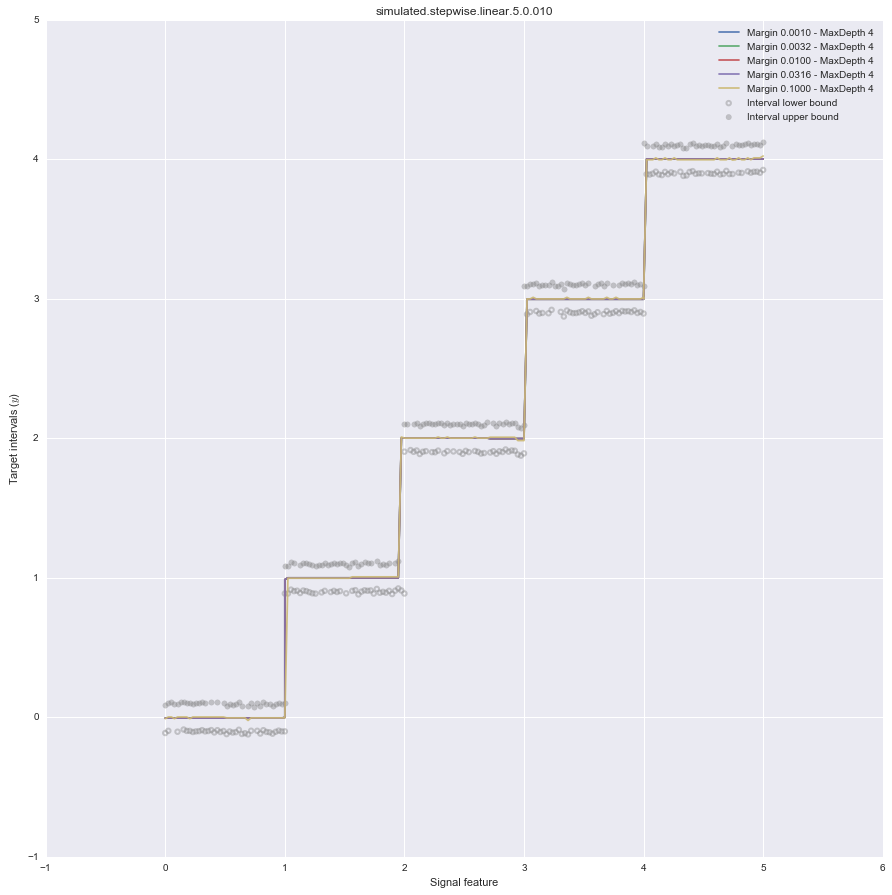

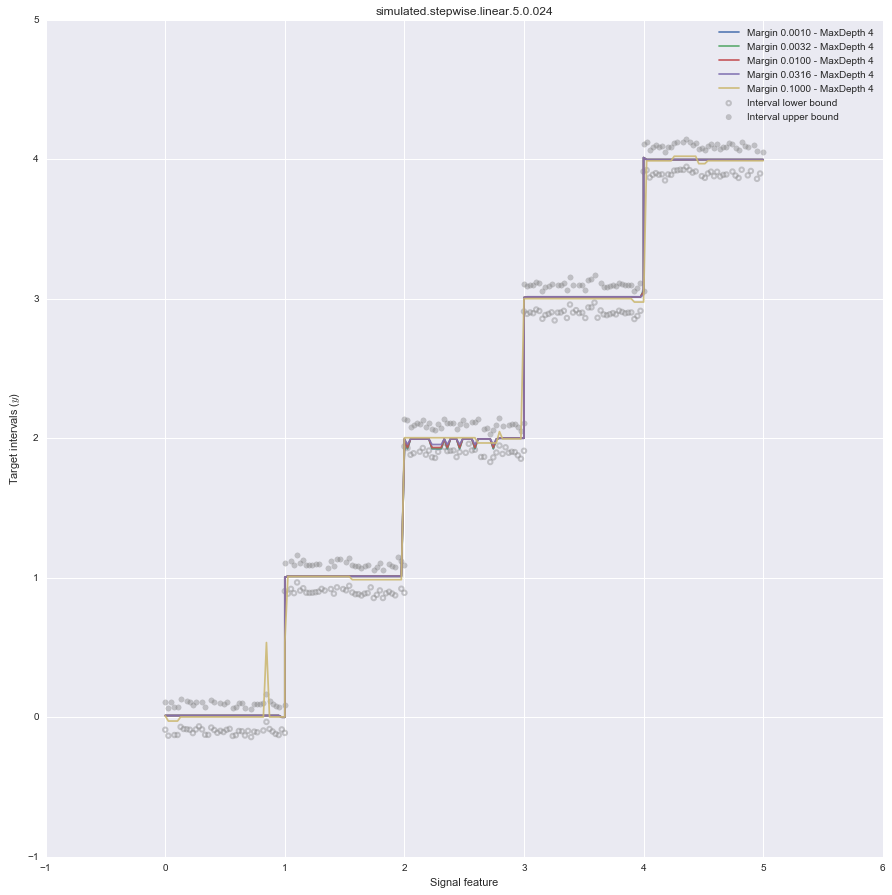

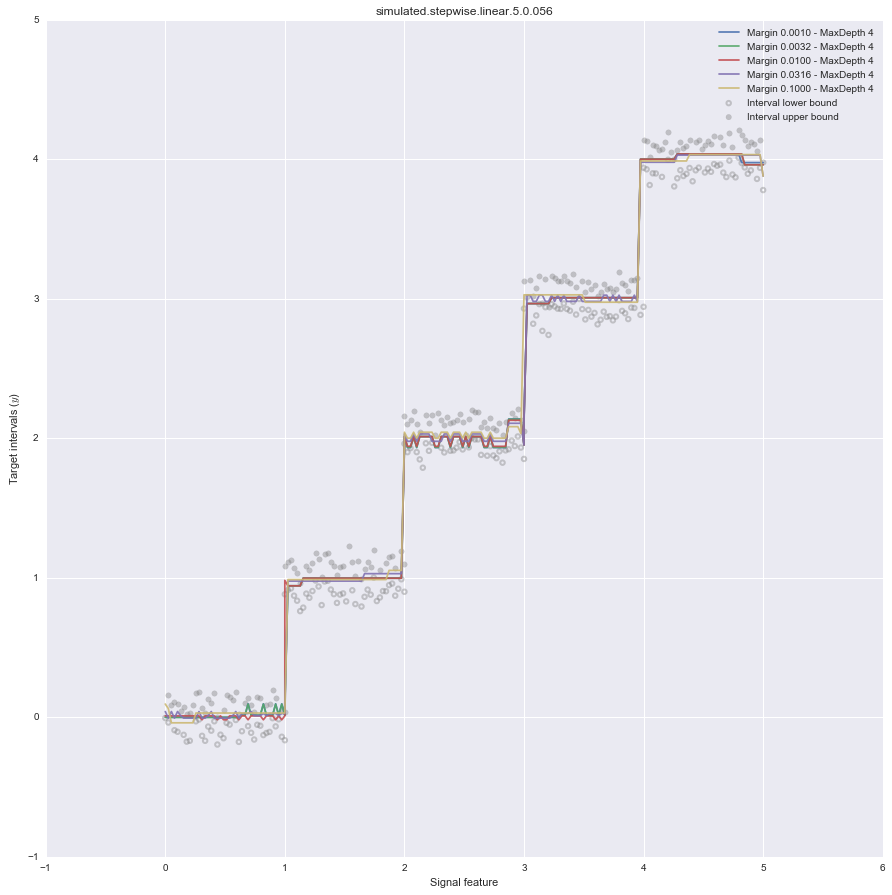

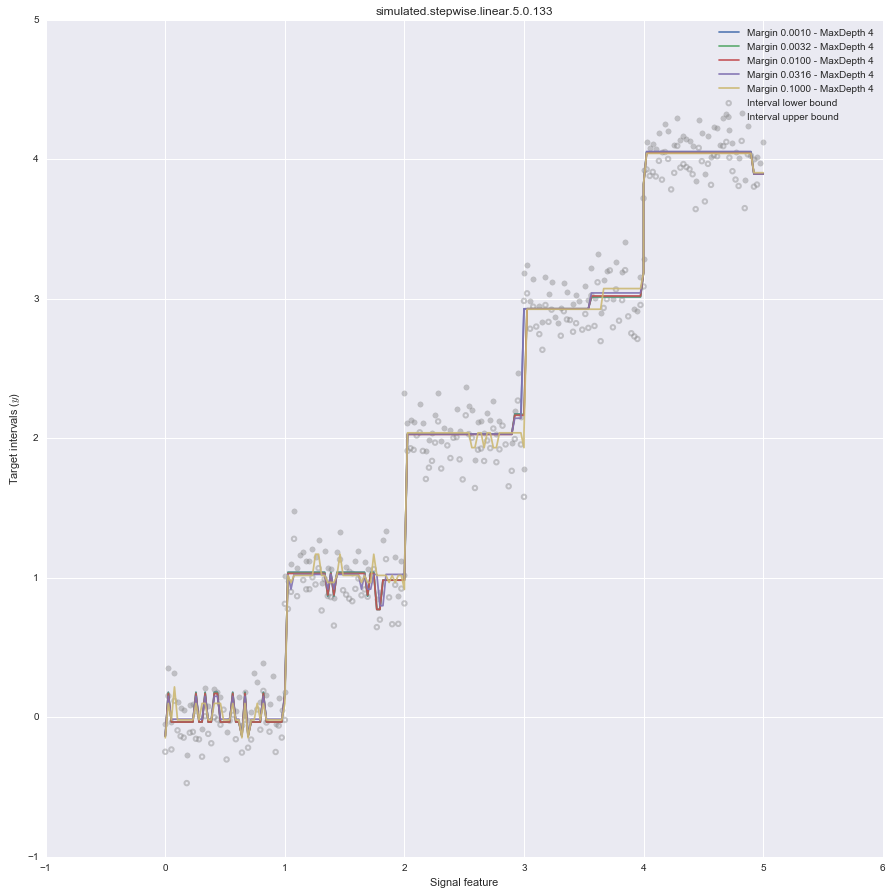

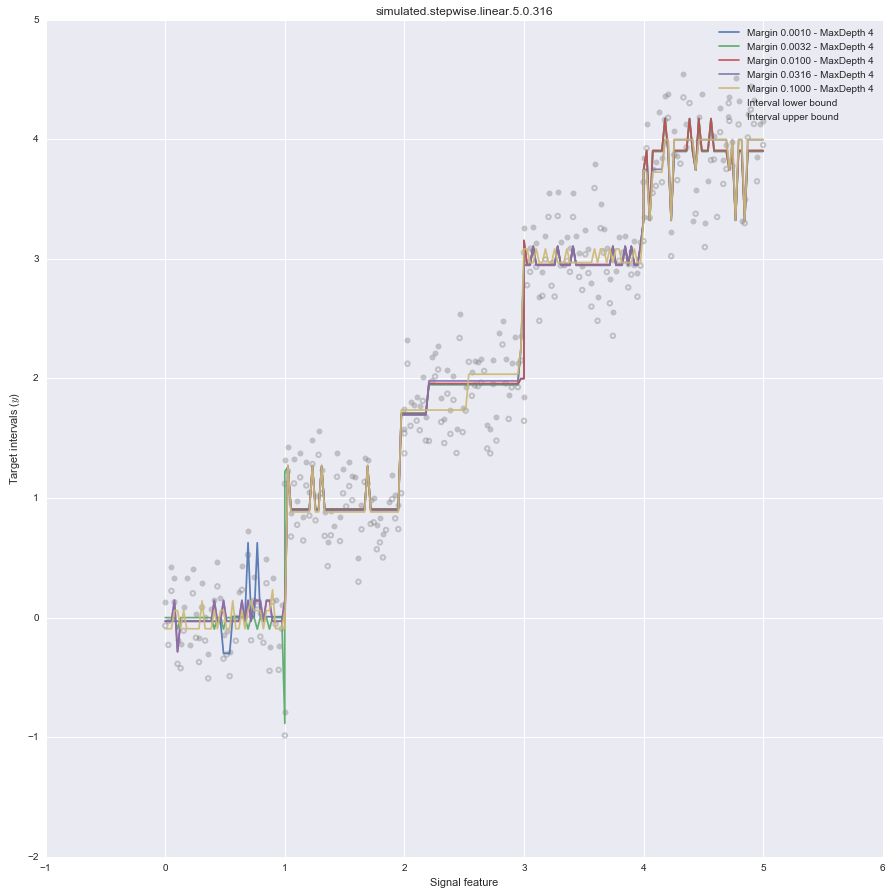

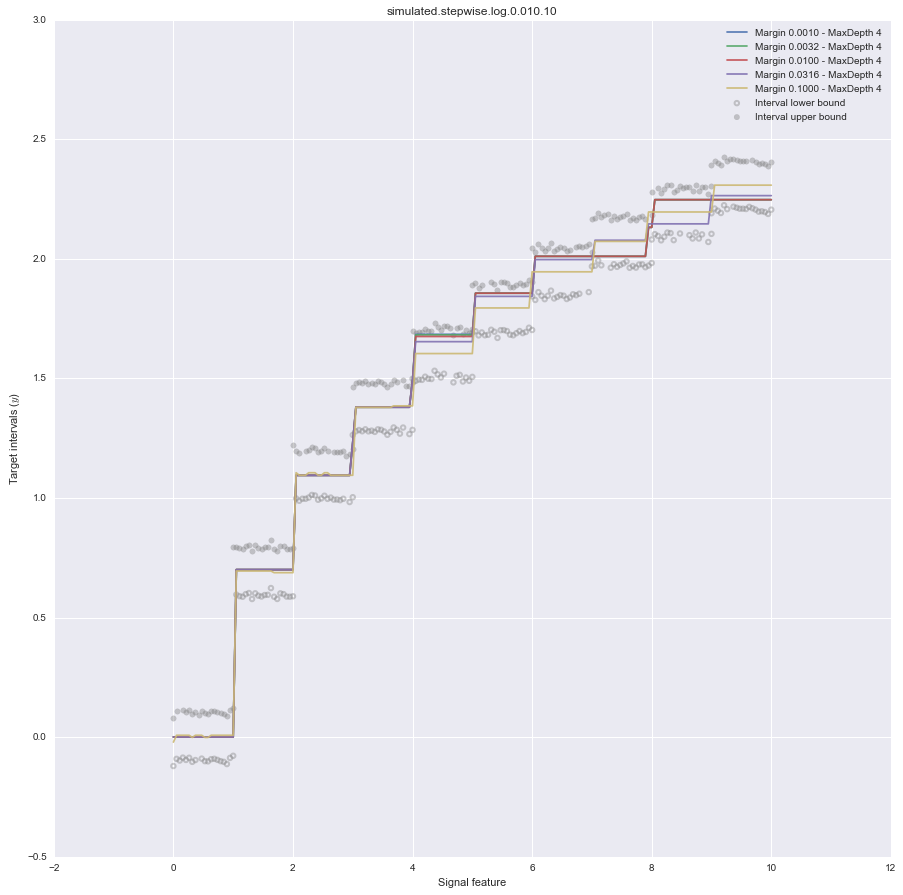

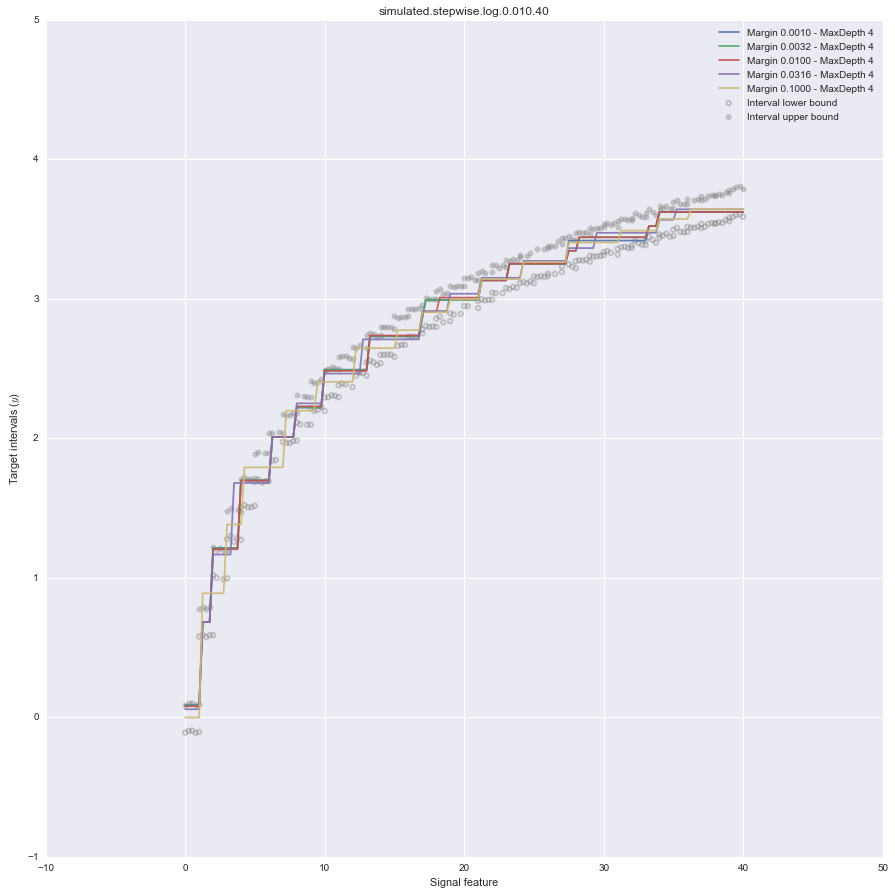

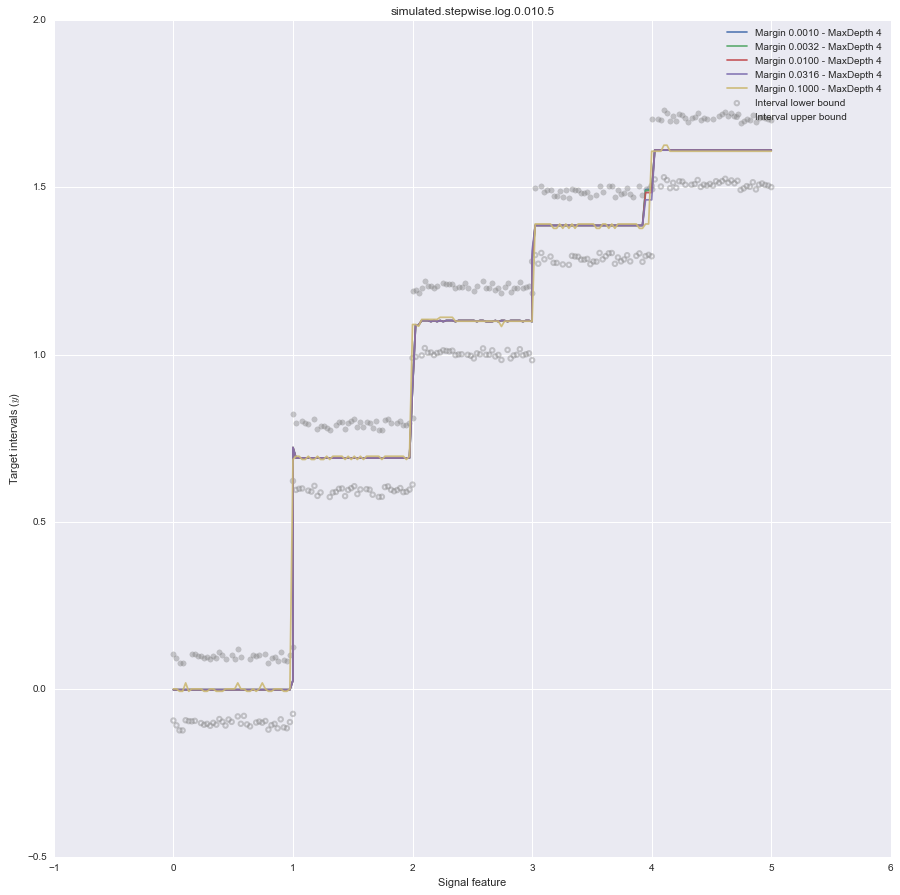

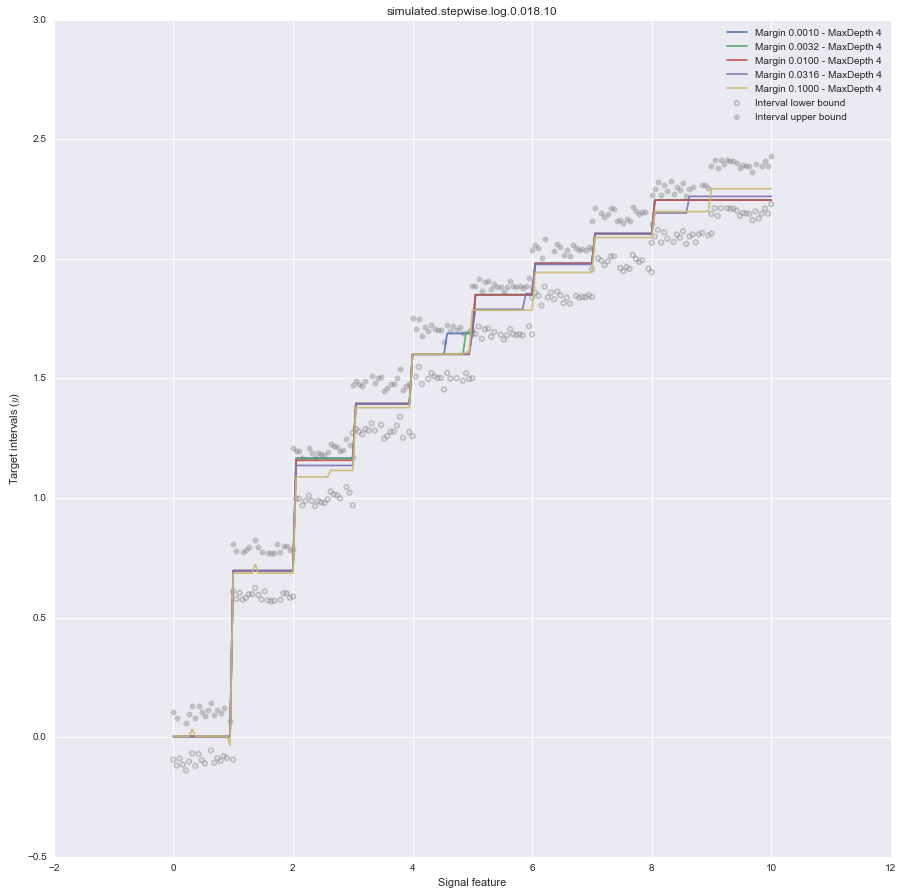

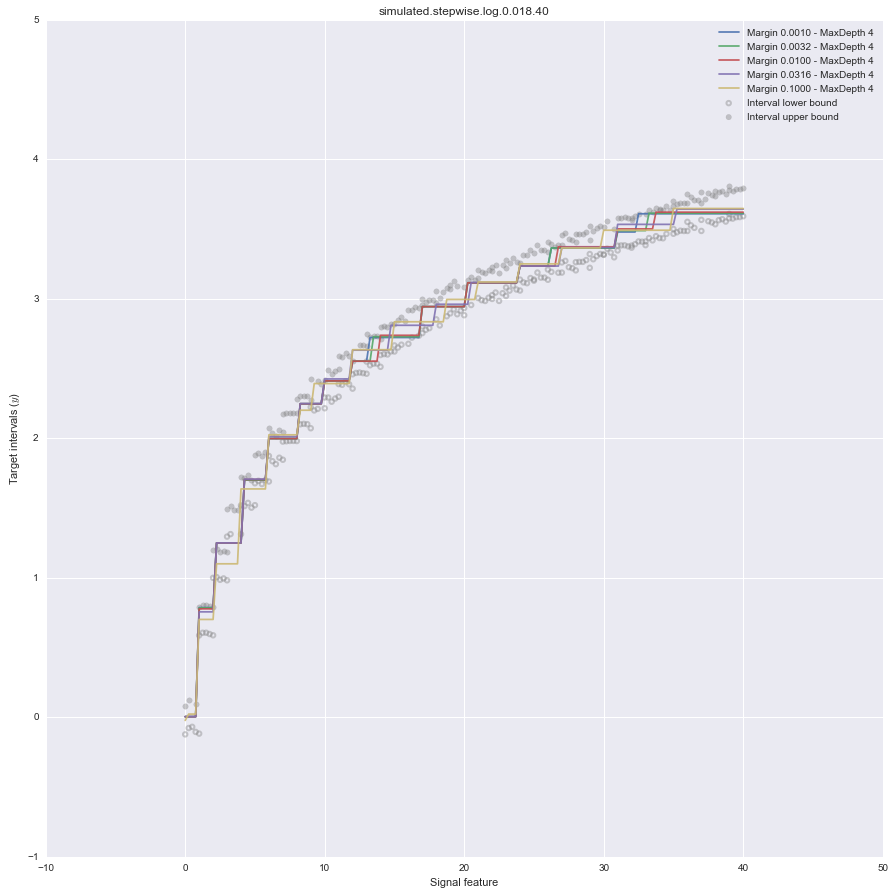

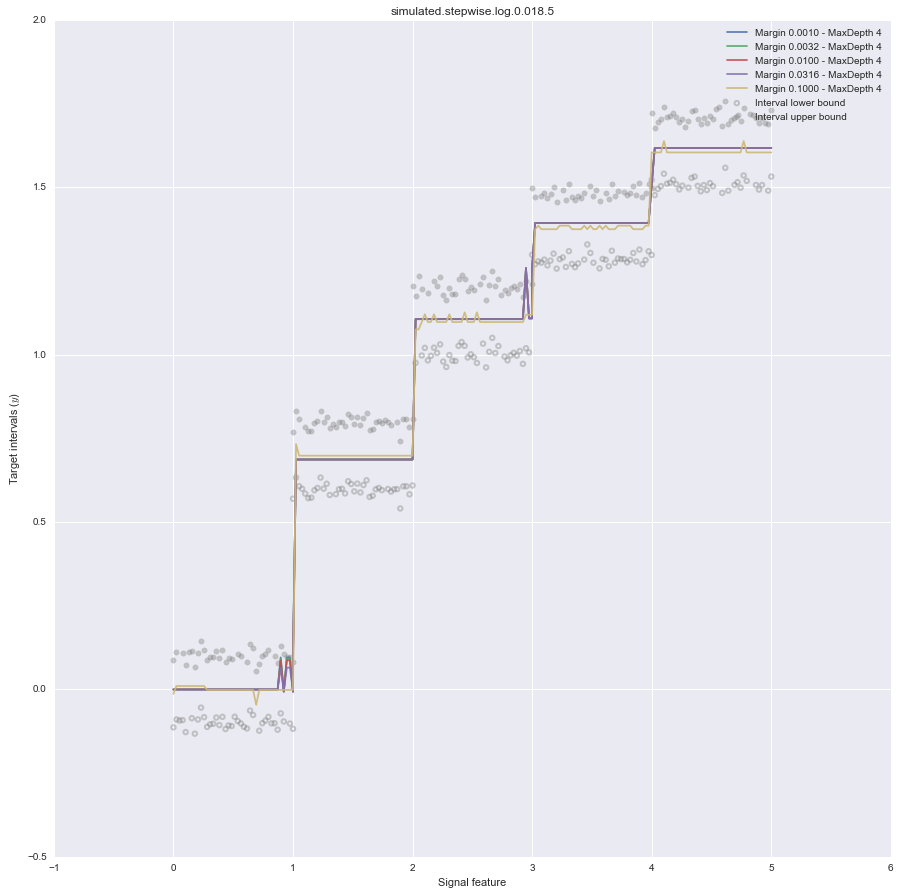

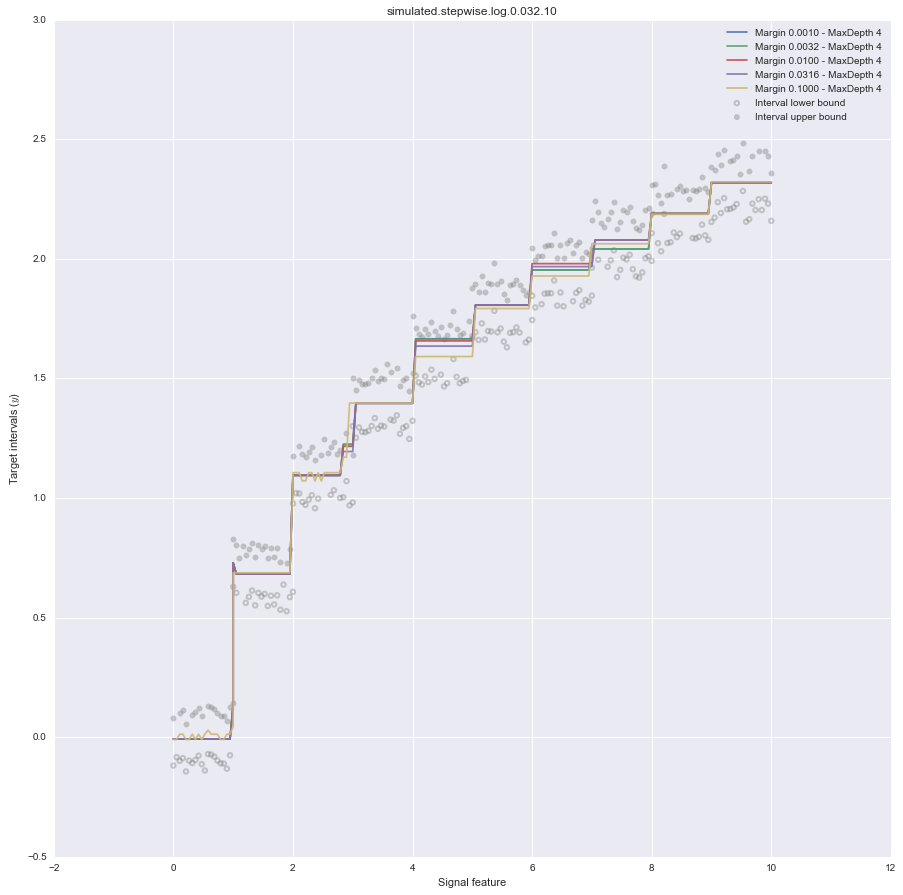

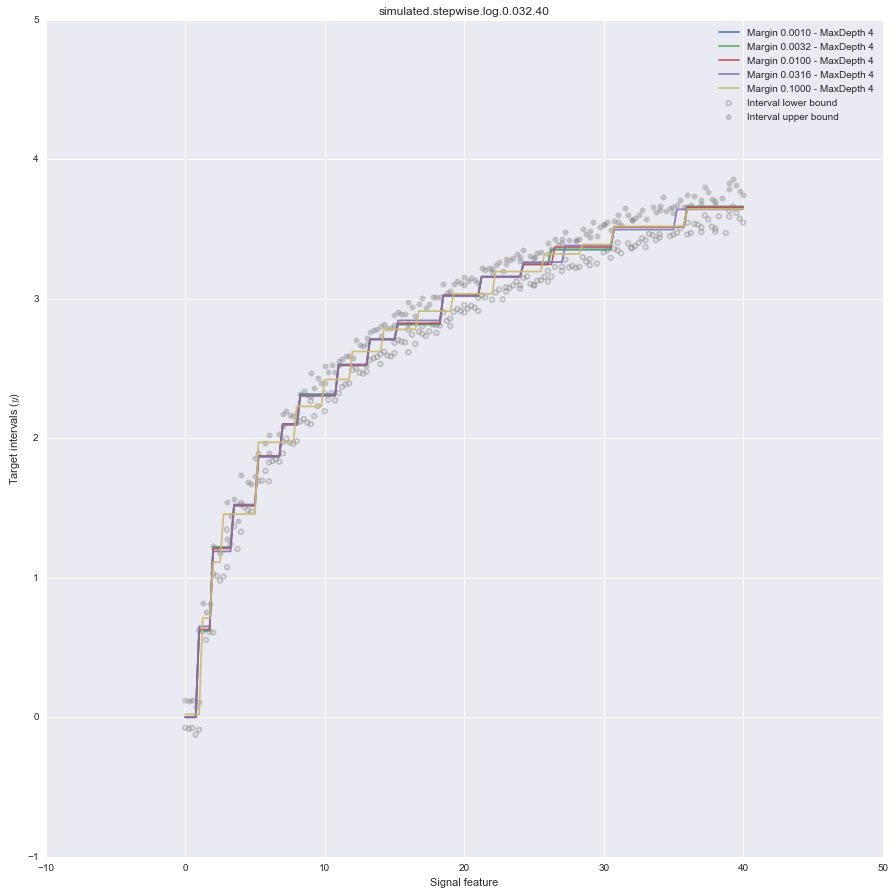

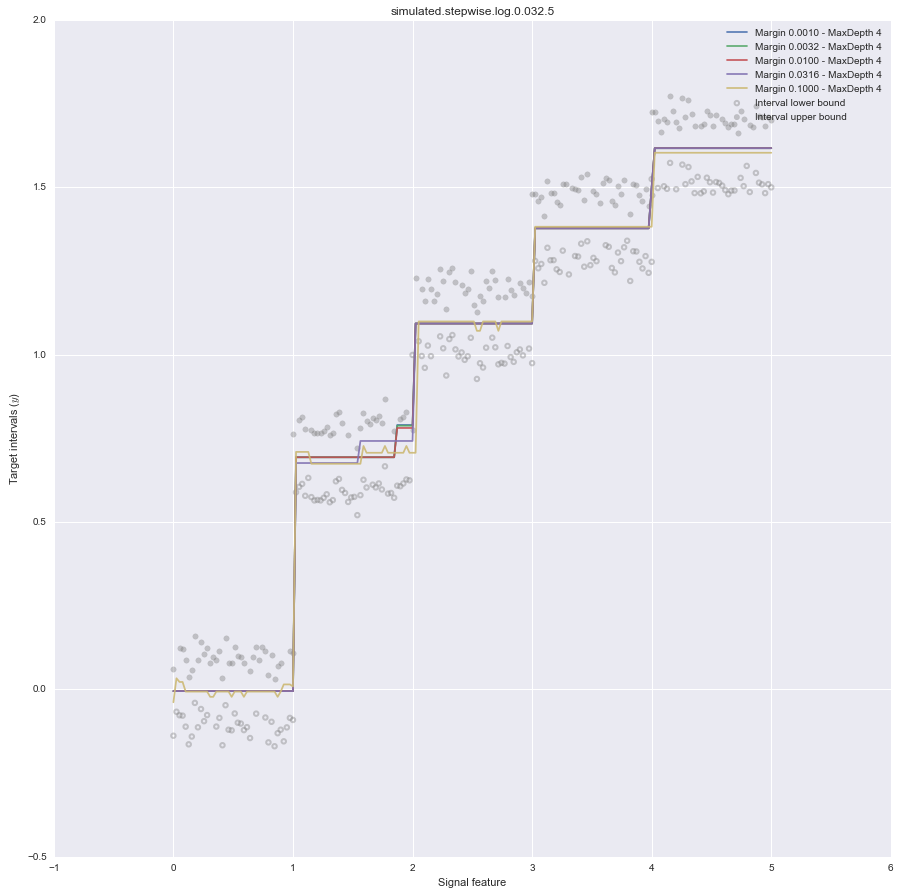

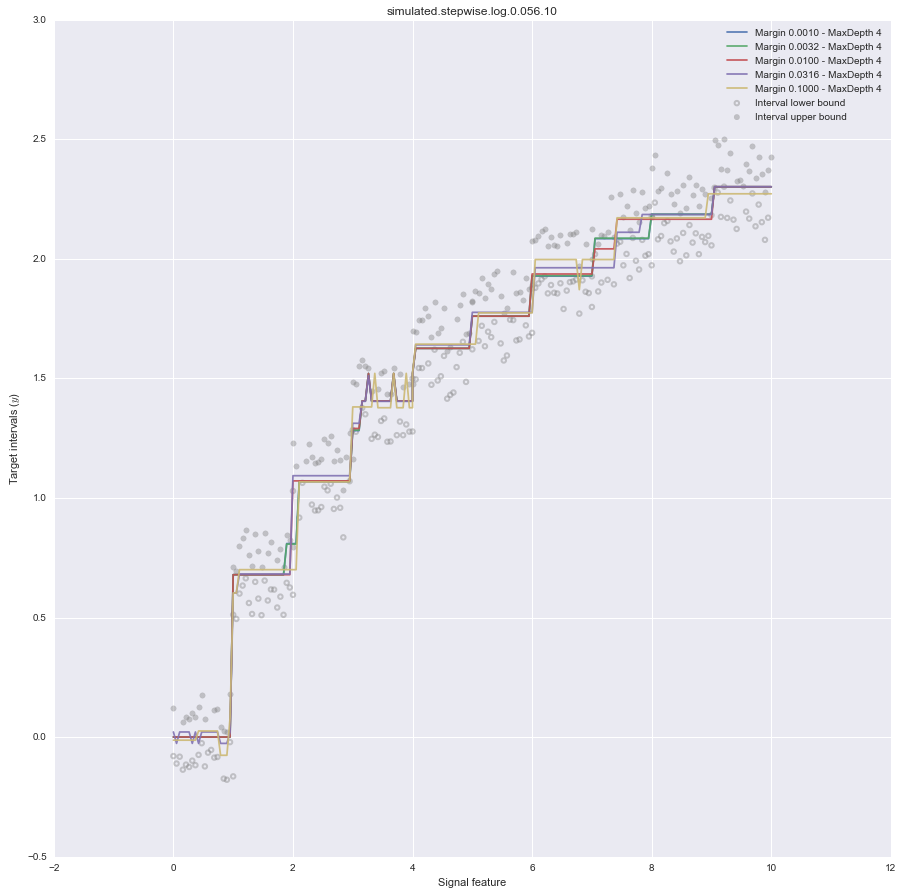

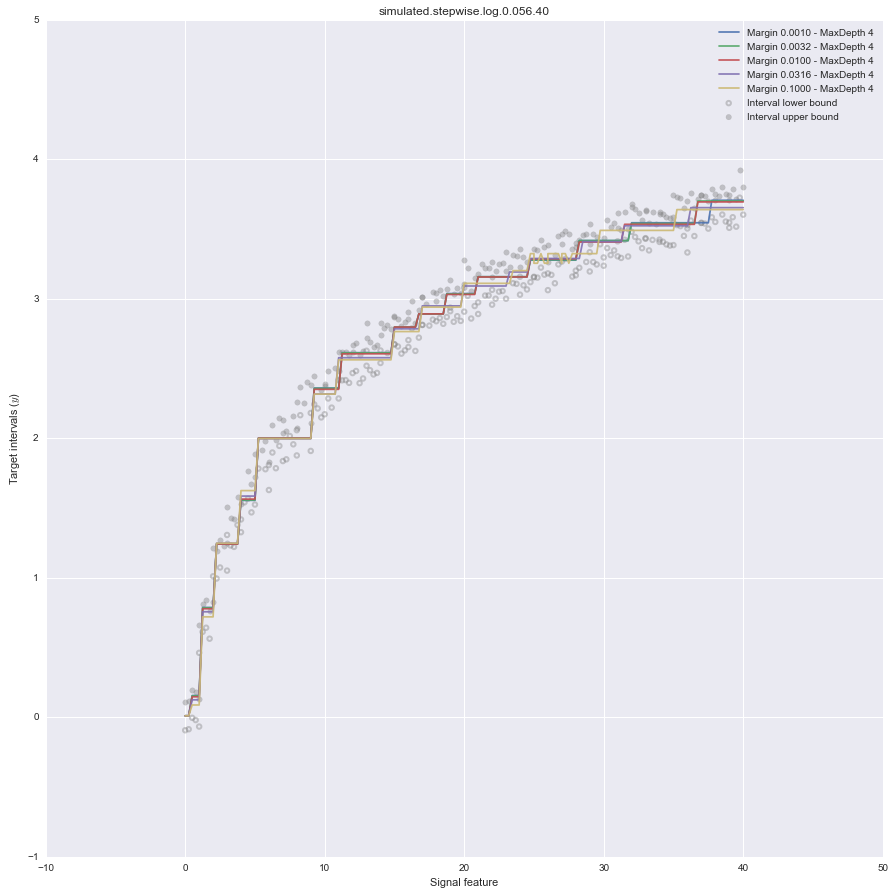

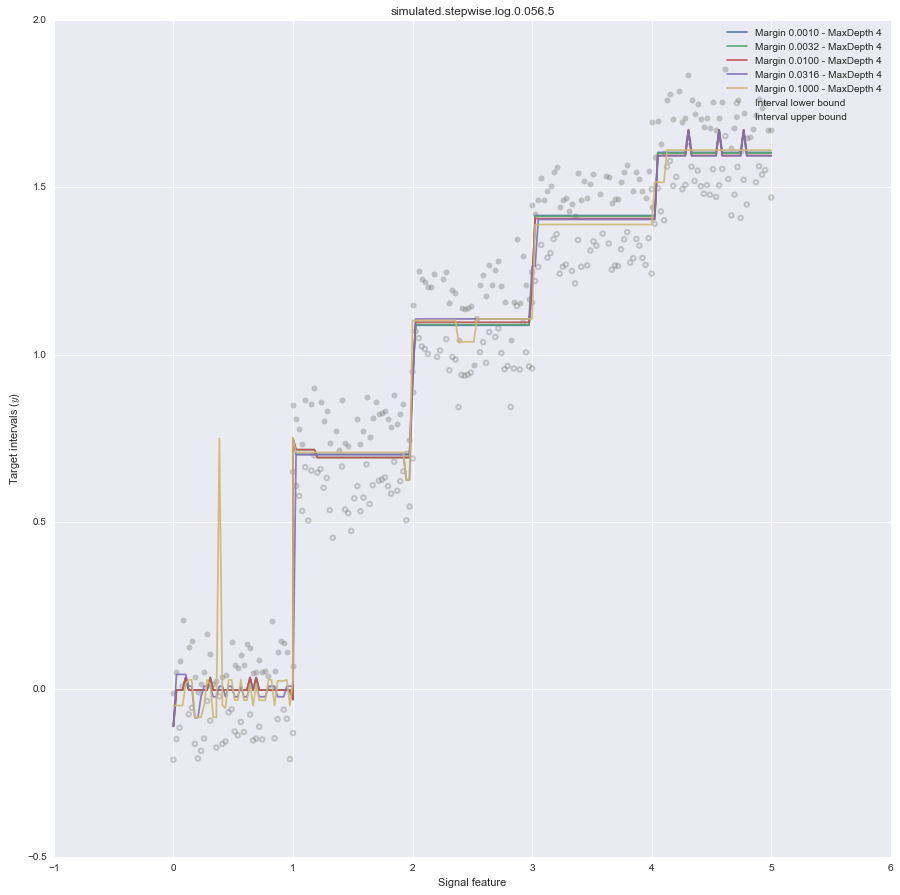

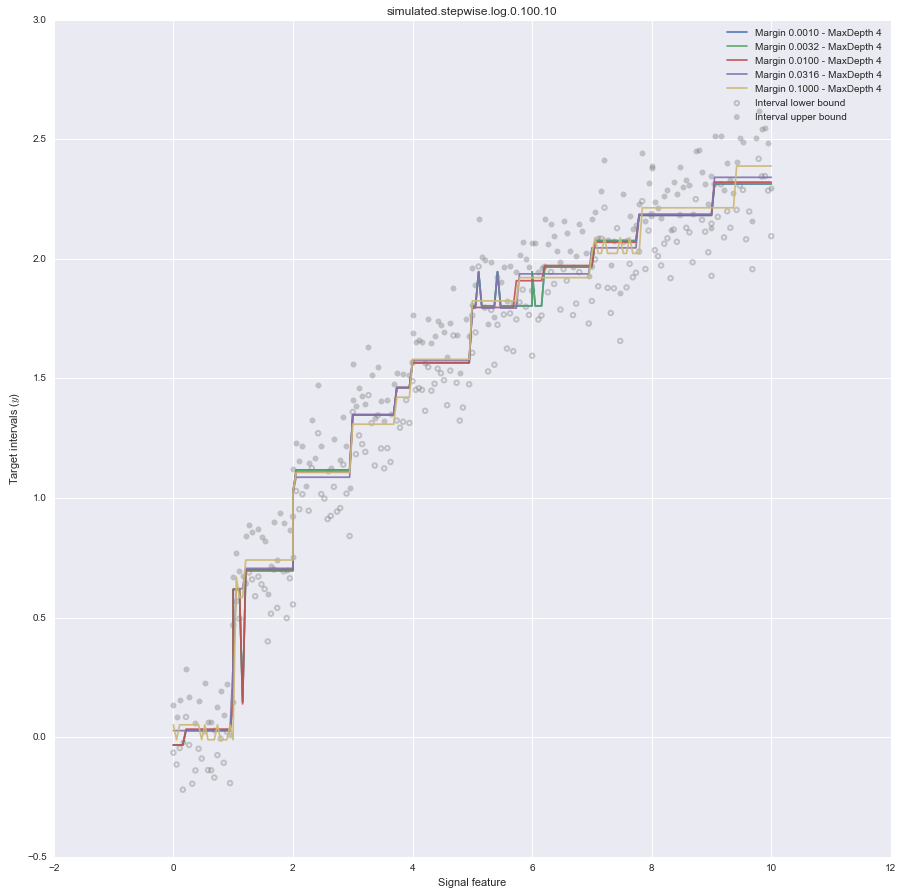

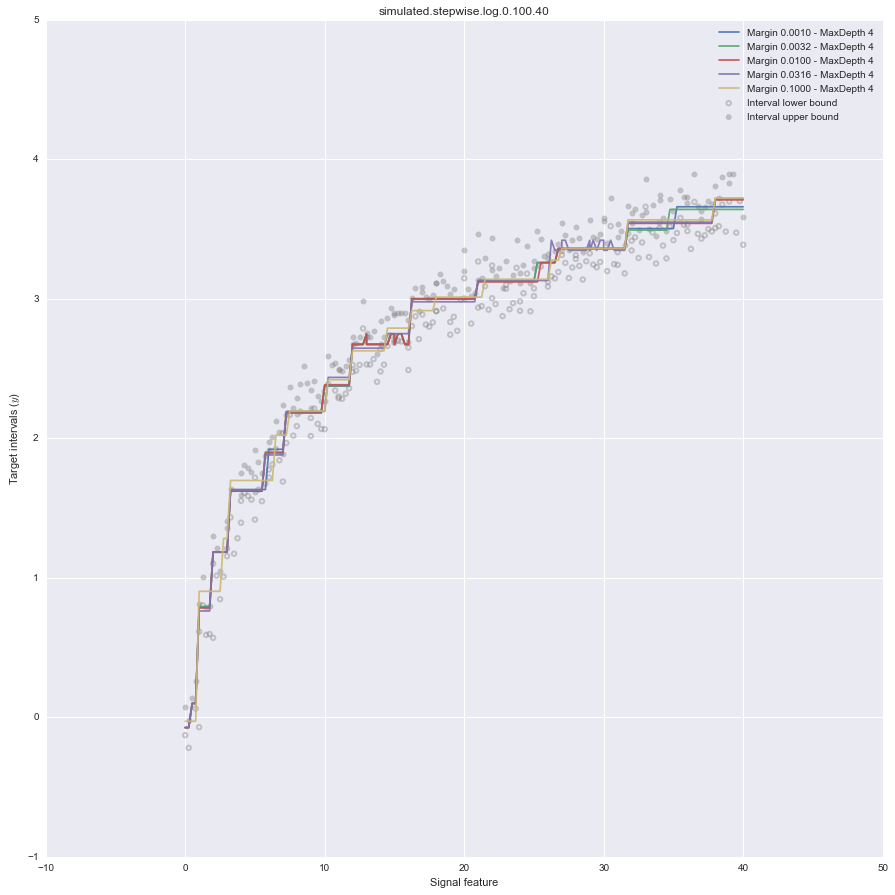

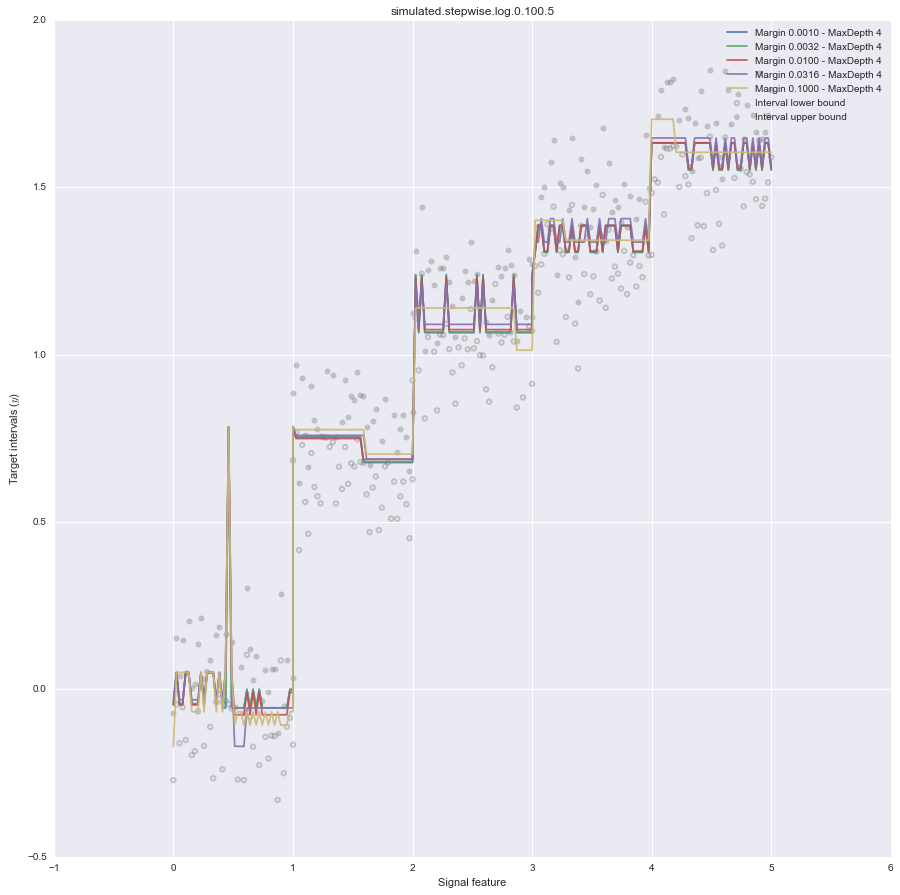

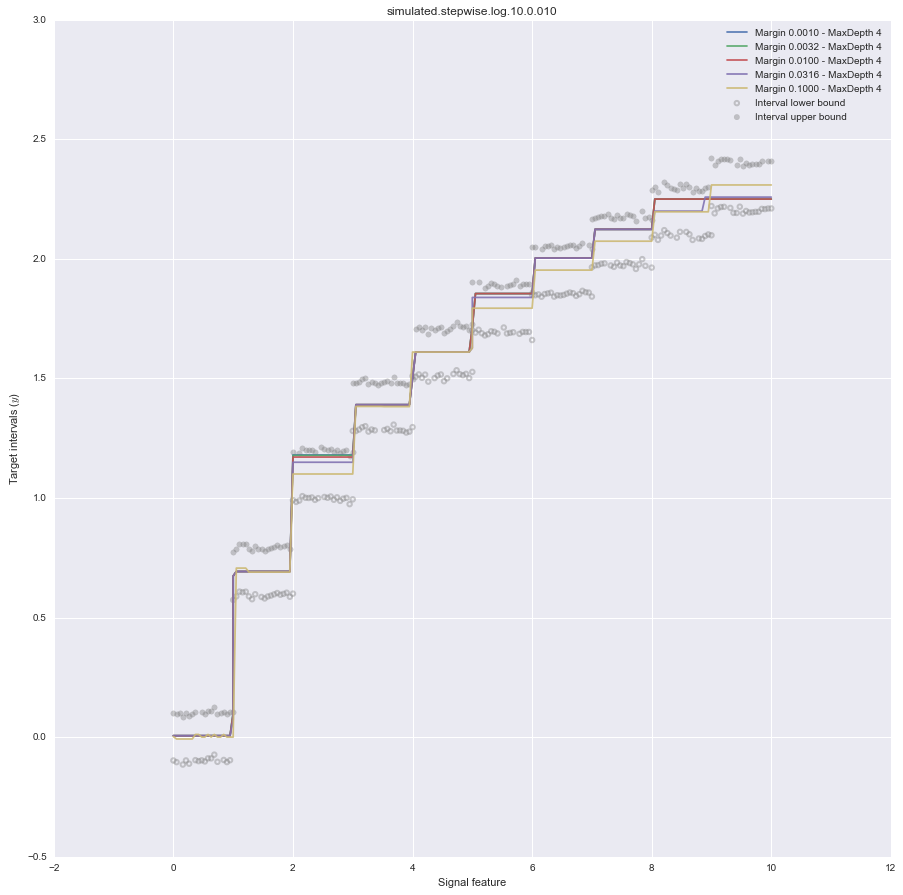

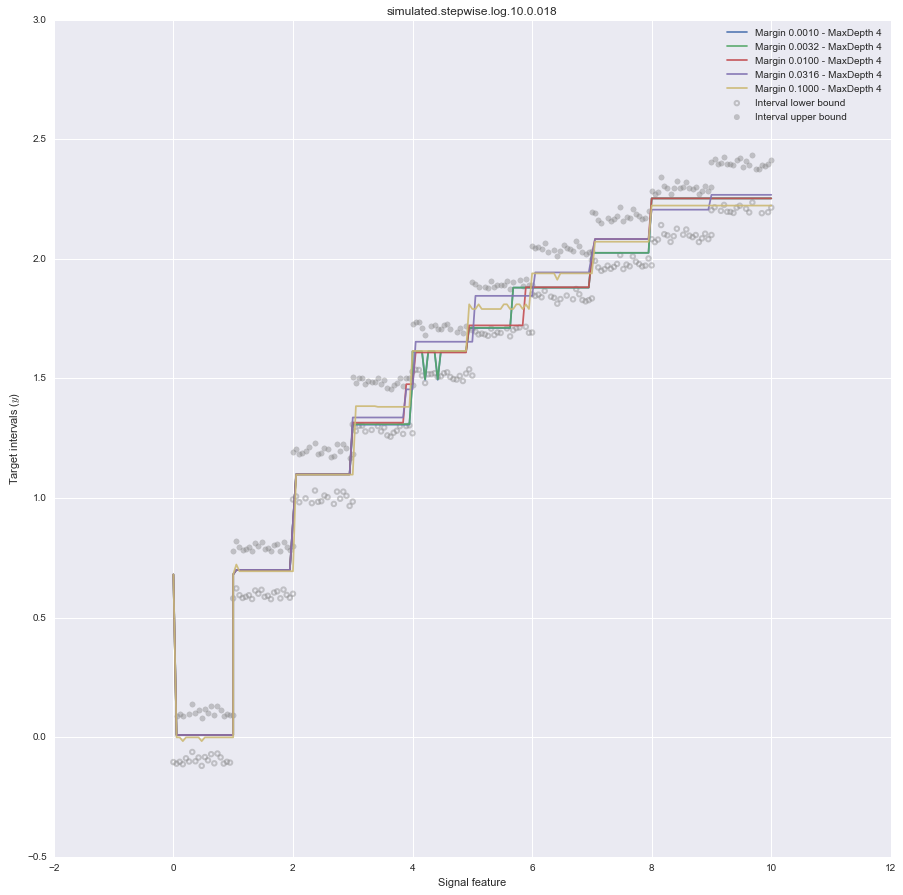

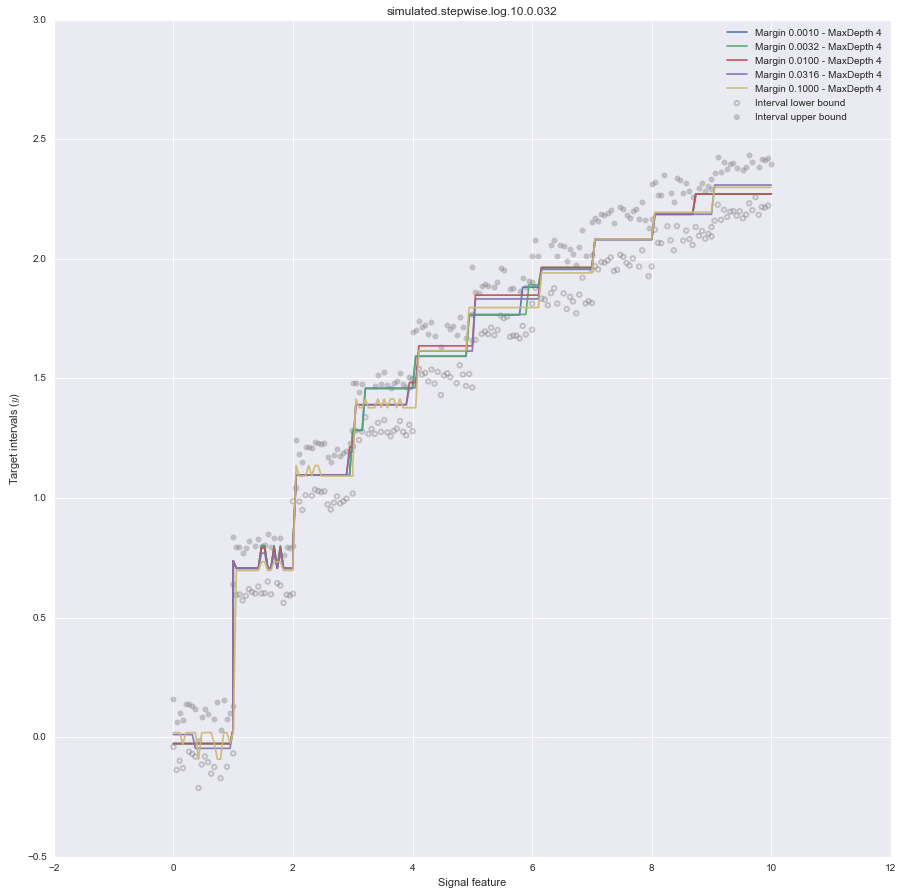

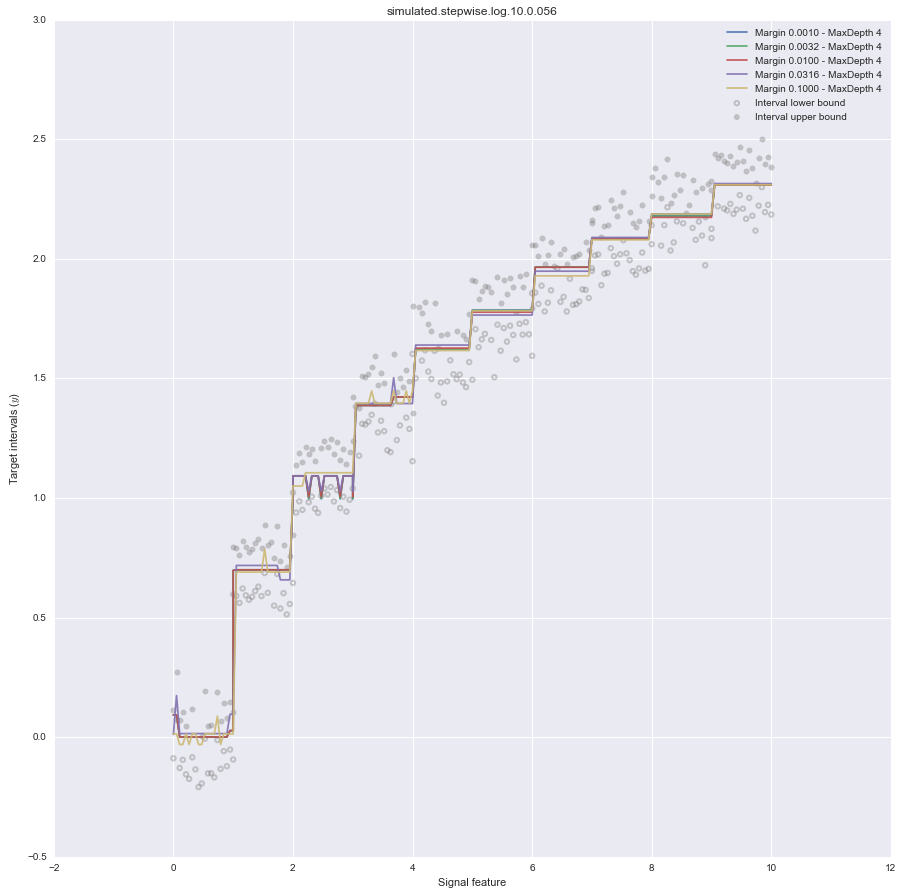

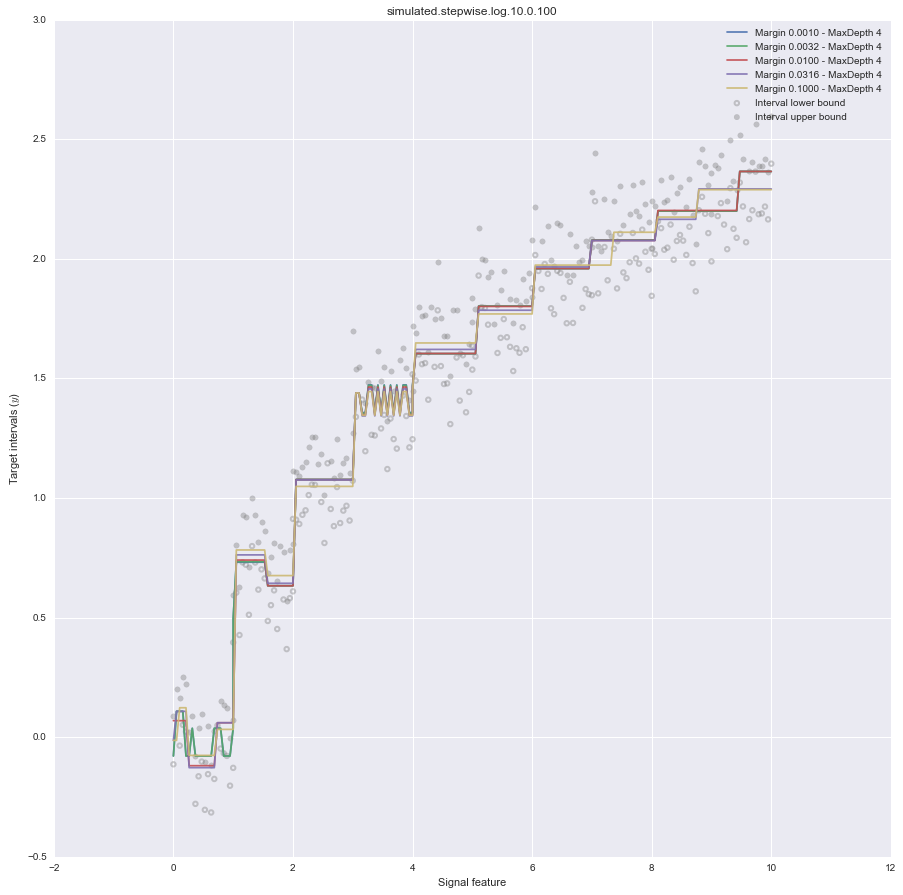

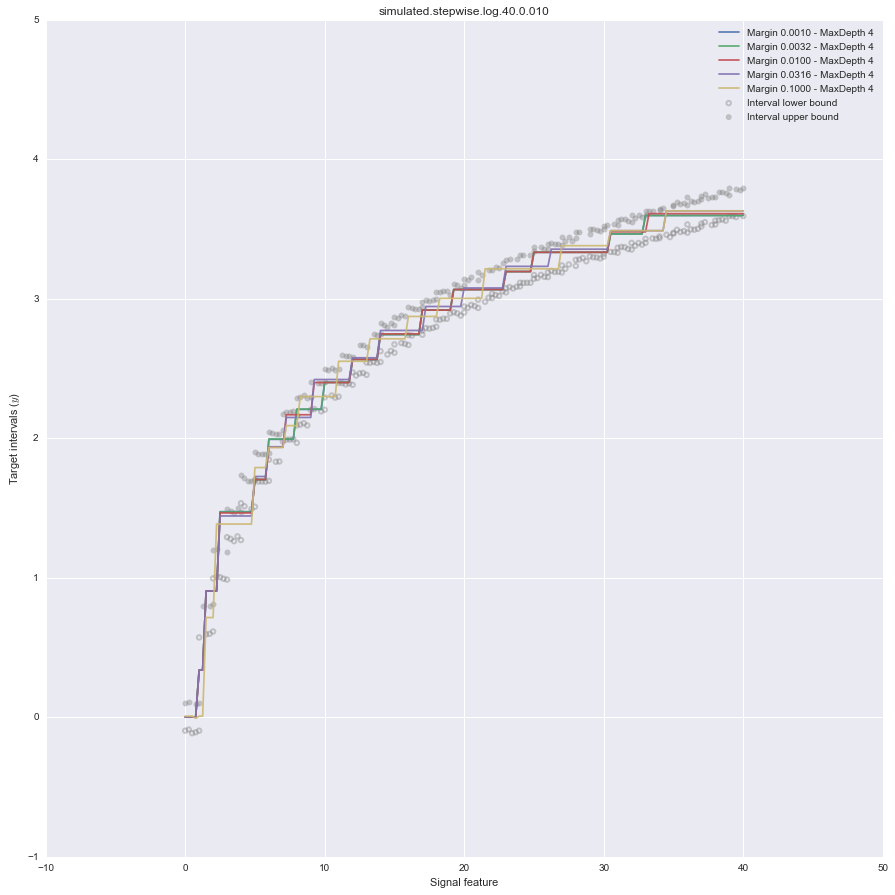

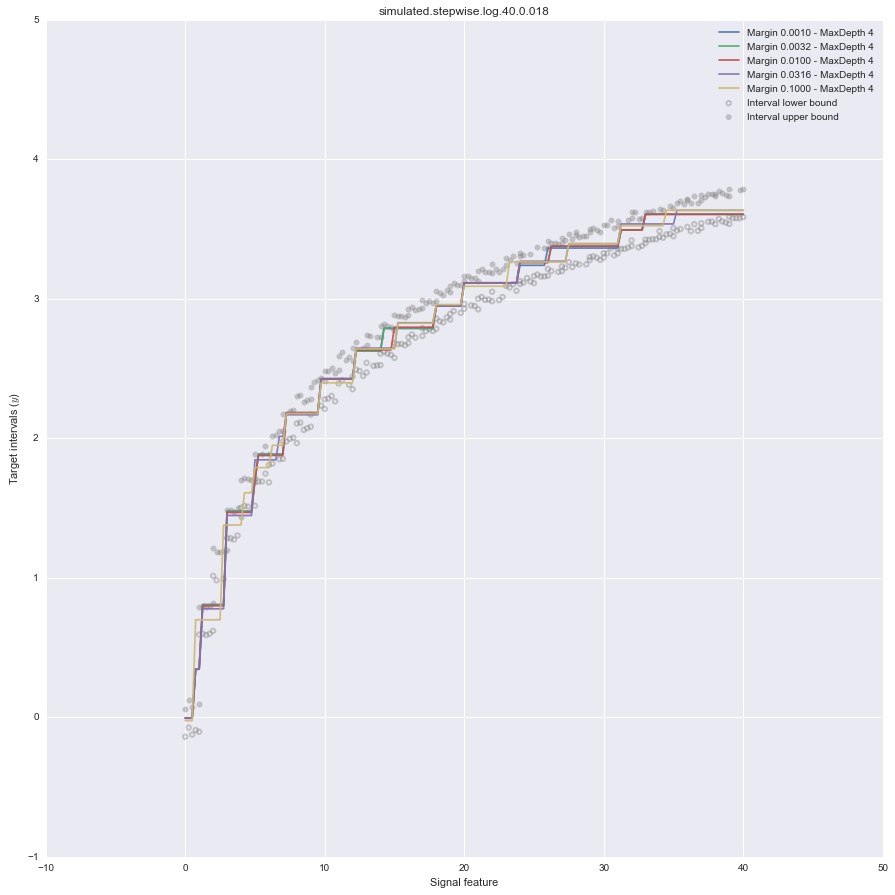

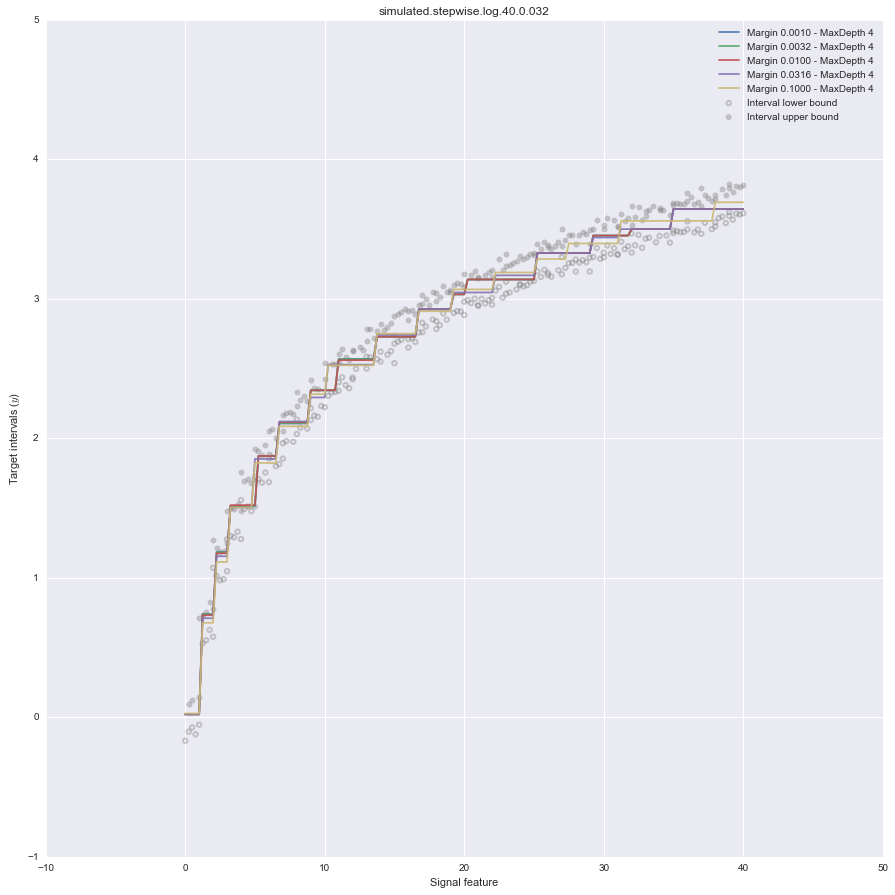

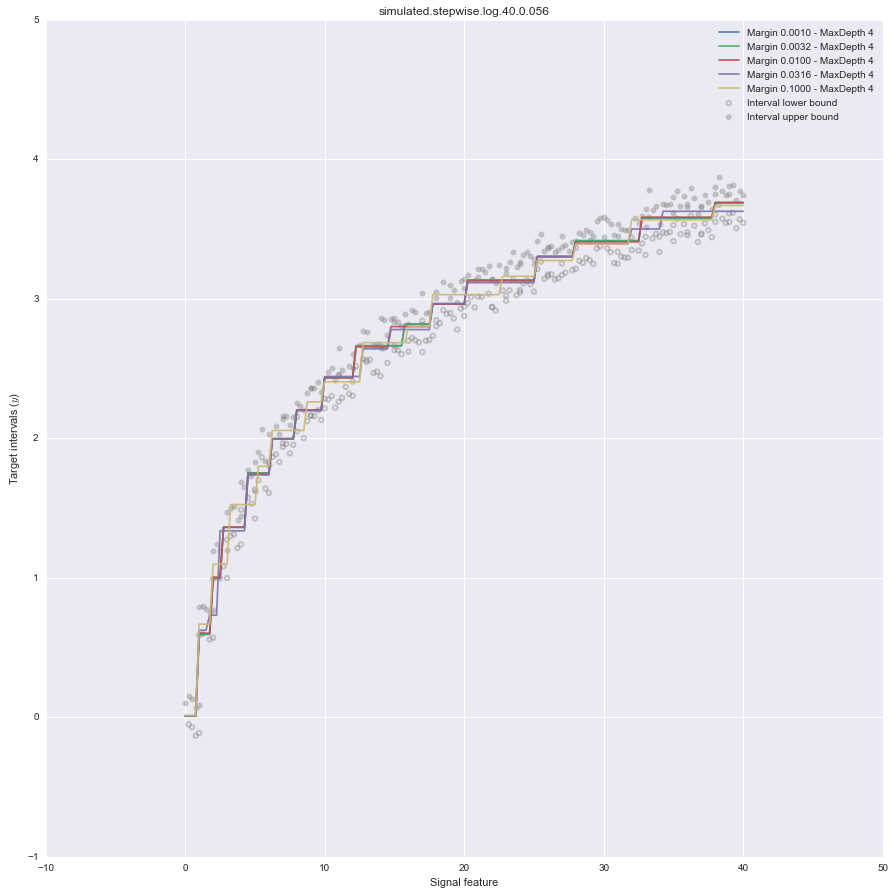

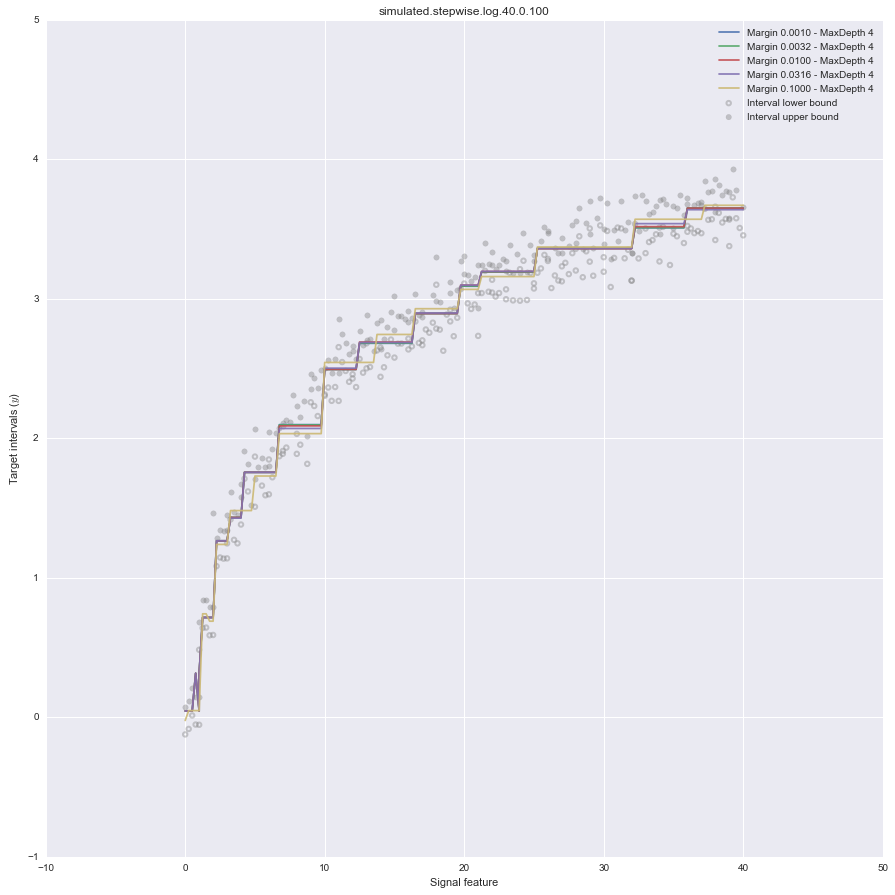

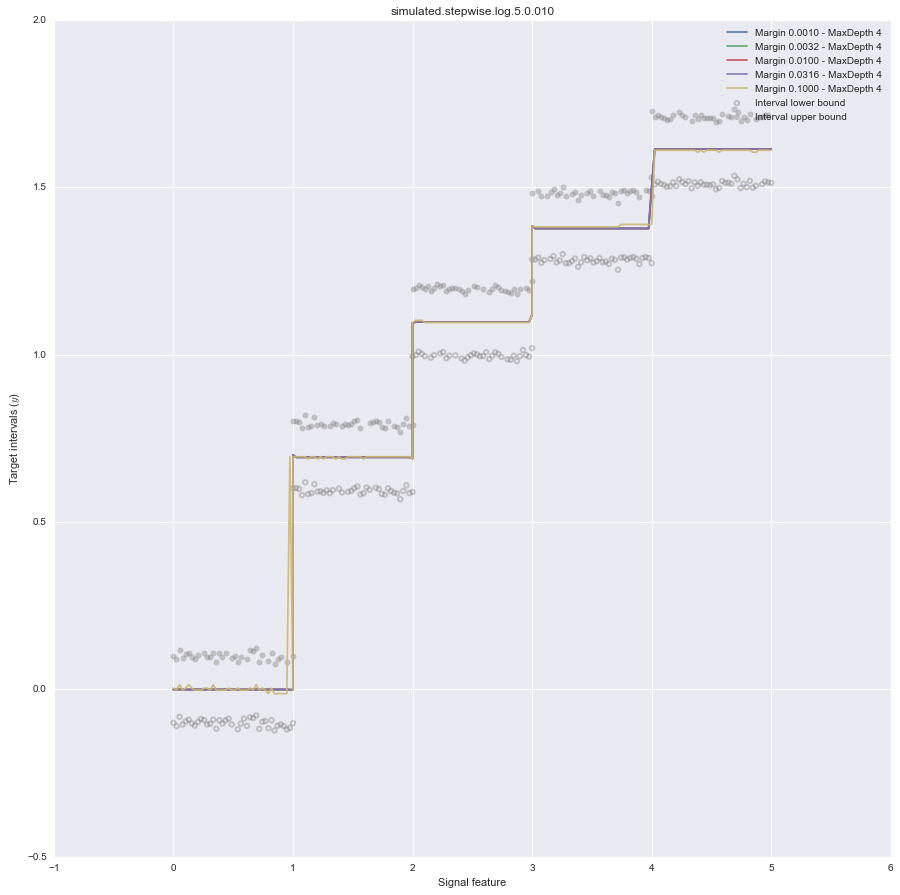

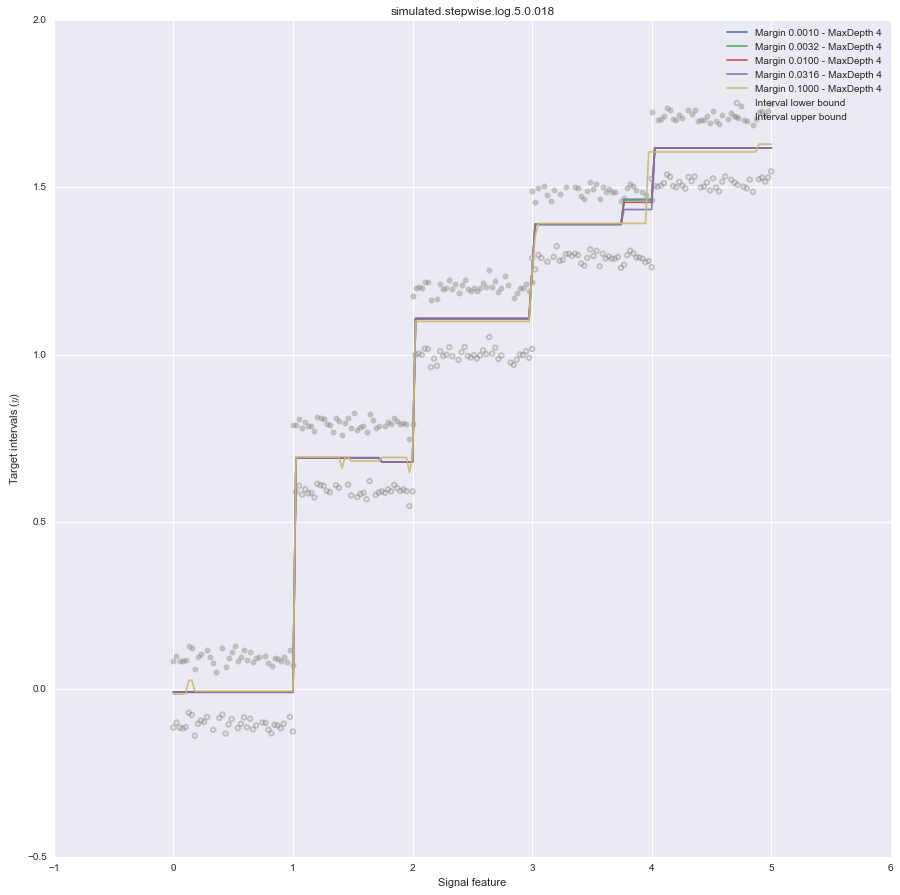

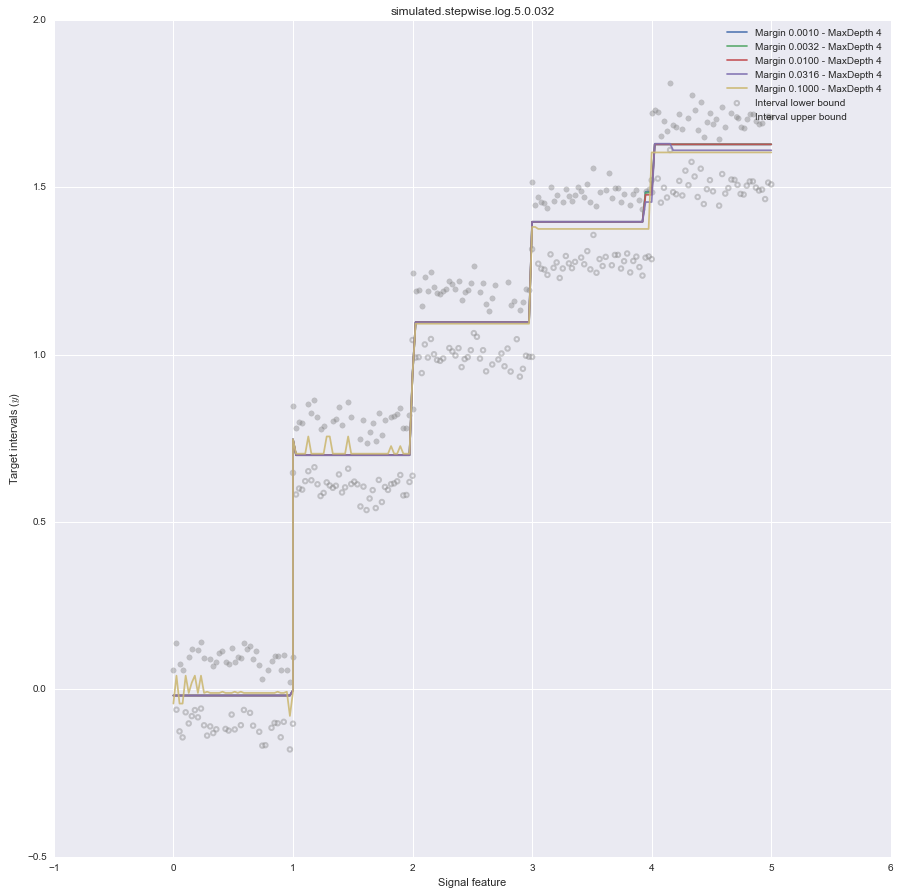

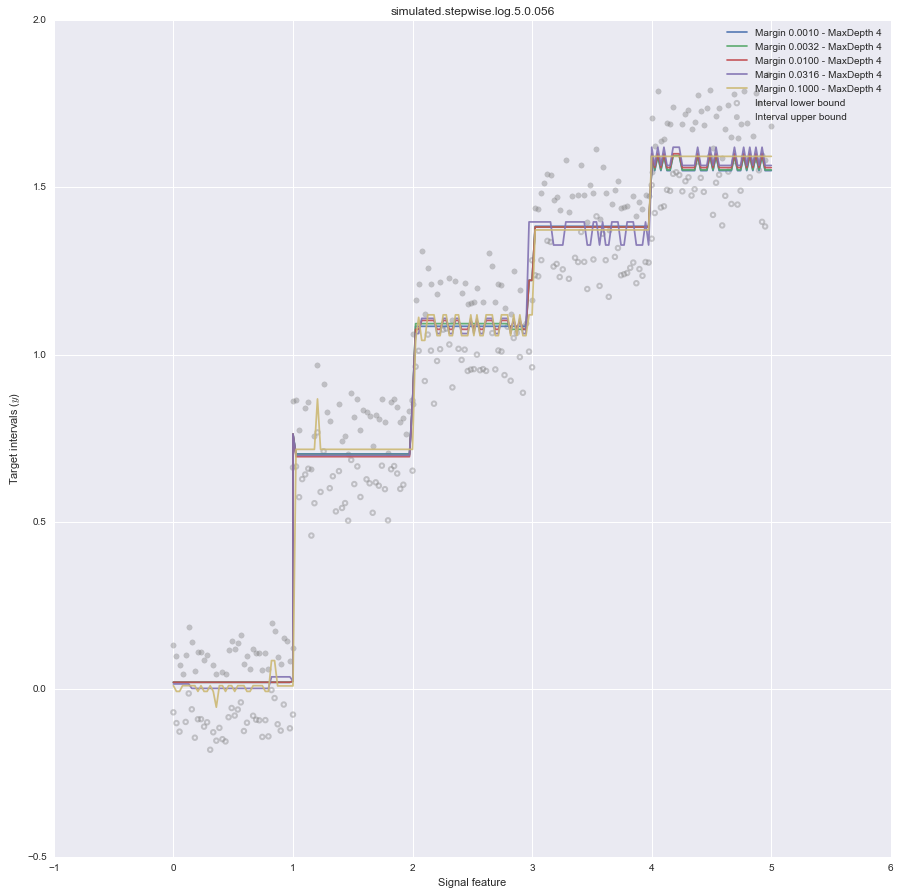

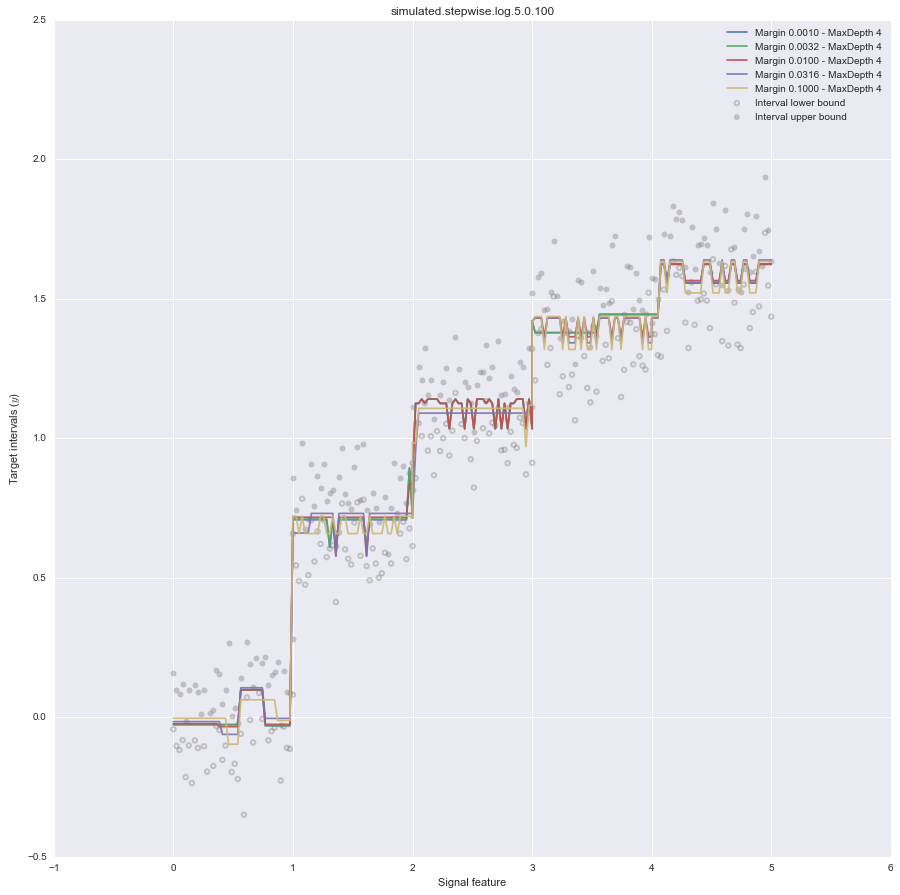

In [10]:
datasets = [d for d in find_datasets("./data") if "simulated" in d.name and "olympics" not in d.name and "stepwise" in d.name]

tree_max_depth = 4

for d in datasets:
    x_relevant = d.X[:, 0]
    y_lower = d.y[:, 0]
    y_upper = d.y[:, 1]

    plt.clf()
    plt.scatter(x_relevant, y_lower, linewidth=2., edgecolor="grey", facecolor="none", alpha=0.4, s=20,
                label="Interval lower bound")
    plt.scatter(x_relevant, y_upper, color="grey", alpha=0.4, s=30, label="Interval upper bound")
    
    # Construct x-axis point sample
    #sampling_step = 0.02
    #x_sample = np.arange(x_relevant.min(), x_relevant.max() + sampling_step, sampling_step)
    #X_pred = np.zeros((x_sample.shape[0], d.X.shape[1]))
    #X_pred[:, 0] = x_sample
    #sample_preds = estimator.predict(X_pred)
    #plt.plot(x_sample, sample_preds, linewidth=2.0, color="black", label="Predicted value")
    
    for m in np.logspace(-3, -1, 5):
        plt.plot(x_relevant, MaxMarginIntervalTree(margin=m, max_depth=tree_max_depth).fit(d.X, d.y).predict(d.X), 
                 alpha=0.9, label="Margin {0:.4f} - MaxDepth {1:d}".format(m, tree_max_depth))
    
    plt.gcf().set_size_inches(15, 15)
    plt.legend()
    plt.xlabel("Signal feature")
    plt.ylabel("Target intervals ($y$)")
    plt.title("{0!s}".format(d.name))
    plt.savefig("./figures/predictions.function.{0!s}.pdf".format(d.name), bbox_inches="tight")
    plt.show()